In [38]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

In [87]:
g = torch.Generator().manual_seed(2147483647)

In [41]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 3080 Laptop GPU


In [43]:
words = open('names.txt', 'r').read().splitlines()

In [44]:
chars = ['.'] + sorted(list(set(''.join(words))))
encode = lambda c: chars.index(c)
decode = lambda i: chars[i]

In [45]:
block_size = 3
vocab_size = len(chars)

In [46]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = encode(c)
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Getting the initial loss function right

11897
      0/ 200000: 25.0534
  10000/ 200000: 2.5154
  20000/ 200000: 2.3246
  30000/ 200000: 2.3359
  40000/ 200000: 2.3783
  50000/ 200000: 2.3355
  60000/ 200000: 2.2633
  70000/ 200000: 2.3177
  80000/ 200000: 2.6525
  90000/ 200000: 2.7191
 100000/ 200000: 2.0307
 110000/ 200000: 2.2111
 120000/ 200000: 2.2525
 130000/ 200000: 1.9685
 140000/ 200000: 2.0442
 150000/ 200000: 2.2161
 160000/ 200000: 2.4536
 170000/ 200000: 2.5352
 180000/ 200000: 2.2406
 190000/ 200000: 2.3654


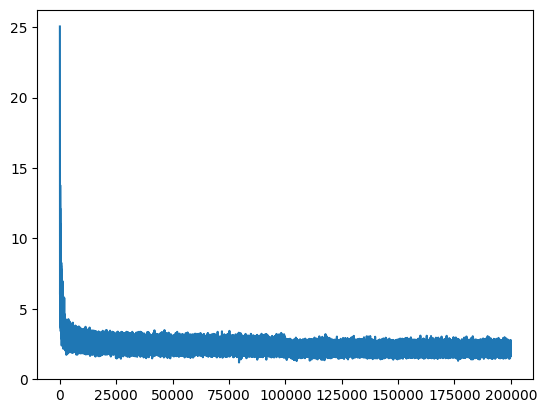

In [24]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation 

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())

_ = plt.plot(lossi)


In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = x @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0557446479797363
val 2.1152327060699463


The initial high loss is a clear signal that there is an issue with the way how we initalize the weights. Initally, the network is very confidently wrong, as indicated by high negative log likelihood. 
Based on the problem stement, we know what the initial loss should roughly be. At the very beginning, the distribution that the network predicts should be roughly uniform - every character should have roughly the same probability of being predicted, since we have not learned anything yet. This observation allows us to calculate the expected starting loss:

<pre>
probability per character = 1/27
-log(1/27) = 3.29
</pre>

So the right starting point should be roughly 3.29.

So we want the logits to be roughly the same for each character, meaning the entroppy is low and everything is equally likely. We can achieve it by setting the bias of the output layeer to zero, and the output weights to some small numbers, hence making the logits very small:

<pre>
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
</pre>

11897
      0/ 200000: 3.3546
  10000/ 200000: 2.3045
  20000/ 200000: 2.3450
  30000/ 200000: 2.4342
  40000/ 200000: 1.7839
  50000/ 200000: 2.2045
  60000/ 200000: 2.5444
  70000/ 200000: 2.3300
  80000/ 200000: 2.3300
  90000/ 200000: 1.8308
 100000/ 200000: 2.1857
 110000/ 200000: 1.9138
 120000/ 200000: 2.4413
 130000/ 200000: 2.5031
 140000/ 200000: 1.8548
 150000/ 200000: 1.8914
 160000/ 200000: 2.2948
 170000/ 200000: 2.2378
 180000/ 200000: 1.7533
 190000/ 200000: 2.0824


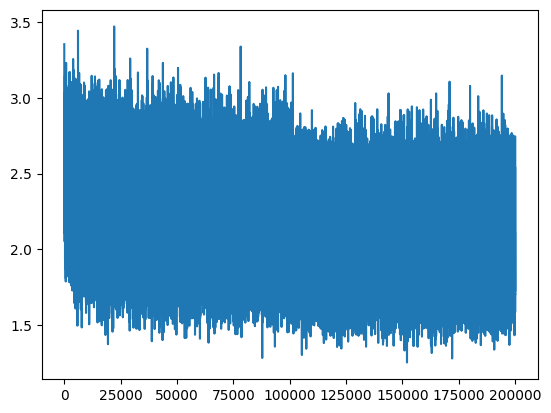

In [27]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation 

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())

_ = plt.plot(lossi)


Now we have taken away the easy part of the optimalization, and the plot of the loss function does not look like a hockey stick anymore. The hockey stick appearance means that the optmization was simply making the weights smaller.

Initial losses with softmax confidently wrong (random weight initialization without scaling):
<pre>
train 2.119840145111084
val 2.162057399749756
</pre>

After fixing softmax initially confidently wrong:
<pre>
train 2.069589138031006
val 2.131074905395508 (the improvement is because we spend more cycles actually optimizing the weights rather than just squashing them in the beginning)
</pre>

# Getting the activations right to prevent vanishing gradients

In [17]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation 

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())
  break

11897
      0/ 200000: 3.3097


The initial loss looks good. Howeve, there is now problem with the value of the hidden activations. Looking at the output of variable `h` after one iteration, we see this:

<pre>
tensor([[-0.9552,  1.0000, -1.0000,  ..., -0.8650,  0.9979, -1.0000],
        [ 0.7501,  0.9931,  1.0000,  ...,  1.0000,  0.9998, -1.0000],
        [-0.9996,  0.9997,  1.0000,  ...,  0.9999,  1.0000,  0.9981],
        ...,
        [-0.9929, -0.9945, -1.0000,  ...,  0.9998, -0.9365, -0.9711],
        [-0.5854, -0.9949,  0.5593,  ...,  0.6392, -0.1373,  1.0000],
        [-0.9479,  1.0000, -1.0000,  ..., -1.0000, -0.9999, -1.0000]],
       grad_fn=<TanhBackward0>)
</pre>

There seems to be many activations with value close to the negative or poistive one - the flat part of the tanh function. This effectively means that the local gradient is zero for these activations, blocking the gradients from flowing during the backpropagation. We can look at the histogram of the hidden activations to see that most of the activations are concentrated at the extreme values of -1 and 1.

![Histogram of hidden state activations](images/histogram1.png)

Such distribution of the activations is caused by the distribution of the pre activations values (`hpreact`) and in particular by the large standard deviation of the preactivations, which puts the inputs to the tanh function well in its flat region.

![Histogram of pre activations](images/hpreact1.png)


In [22]:
print(f"hpreact.mean(): {hpreact.mean()}, hpreact.std(): {hpreact.std()}")
print(f"h.mean(): {h.mean()}, h.std(): {h.std()}")

hpreact.mean(): 0.03950118646025658, hpreact.std(): 5.70084285736084
h.mean(): 0.0019816465210169554, h.std(): 0.9224614500999451


Because the variance of preactivations is so large, a lot of inputrs to the tanh function are in the flat, saturated region. Since the gradient flowing thorugh tanh always decreases by `1-t^2` factor (which is the derivative of tanh), if t is 1 the local gradient is 0. The concern is that if all the tanh outputs are in the flat regions, the gradients flowing backwards wil be fully blocked.

In the plot below, white pixels are inactive neurons and black pixels are inactive neurons (for a given batch example).

![Active/Inactive Neurons](images/dead1.png)

If the entire column is white, this means that for every example in the batch the activation is in the flat region, and the neuron is esentially dead. Such nerons will will never learn.

The good thing in this case is that for each neuron there is at least one example which triggers it, so all neuron will learn.

What can happen during training is that a high gradient knocks a neuron off into this dead space and from that point on, the neuron never learns.

To fix the issue of so many activations being in the dead space, the outputs of the linear layer before the activation function have to be smaller. In fact, we want them to be roughly guassian.

We want the value of this expression `hpreact = embcat @ W1 + b1 # hidden layer pre-activation` to be close to zero. It is okey to set the biases to something small which is not zero. We also want to squash the weights, but not set them to zero:

```
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
```

In [32]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation 

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())

11897
      0/ 200000: 3.4940
  10000/ 200000: 1.9201
  20000/ 200000: 2.1985
  30000/ 200000: 2.1613
  40000/ 200000: 1.9802
  50000/ 200000: 2.1550
  60000/ 200000: 2.4511
  70000/ 200000: 2.2300
  80000/ 200000: 2.2980
  90000/ 200000: 2.1072
 100000/ 200000: 2.1910
 110000/ 200000: 1.9414
 120000/ 200000: 2.2594
 130000/ 200000: 1.8581
 140000/ 200000: 1.9340
 150000/ 200000: 2.1302
 160000/ 200000: 1.7001
 170000/ 200000: 1.9541
 180000/ 200000: 1.9002
 190000/ 200000: 2.4037


Now the activations, preactivations and the inactive/active neurons look like that:

![Histogram of hidden state activations](images/histogram2.png)

![Histogram of pre activations](images/hpreact2.png)

![Active/Inactive neurons](images/dead2.png)

The activations are now not saturated, because the variance of the preactivations is lower.


Initial losses with softmax confidently wrong (random weight initialization without scaling):
<pre>
train 2.119840145111084
val 2.162057399749756
</pre>

After fixing softmax initially confidently wrong:
<pre>
train 2.069589138031006
val 2.131074905395508
</pre>

Fixing tanh too saturated at initialization:
<pre>
train 2.0557446479797363
val 2.1152327060699463
</pre>

# Kaiming initialization

tensor(0.0119) tensor(0.9908)
tensor(0.0097) tensor(3.0445)


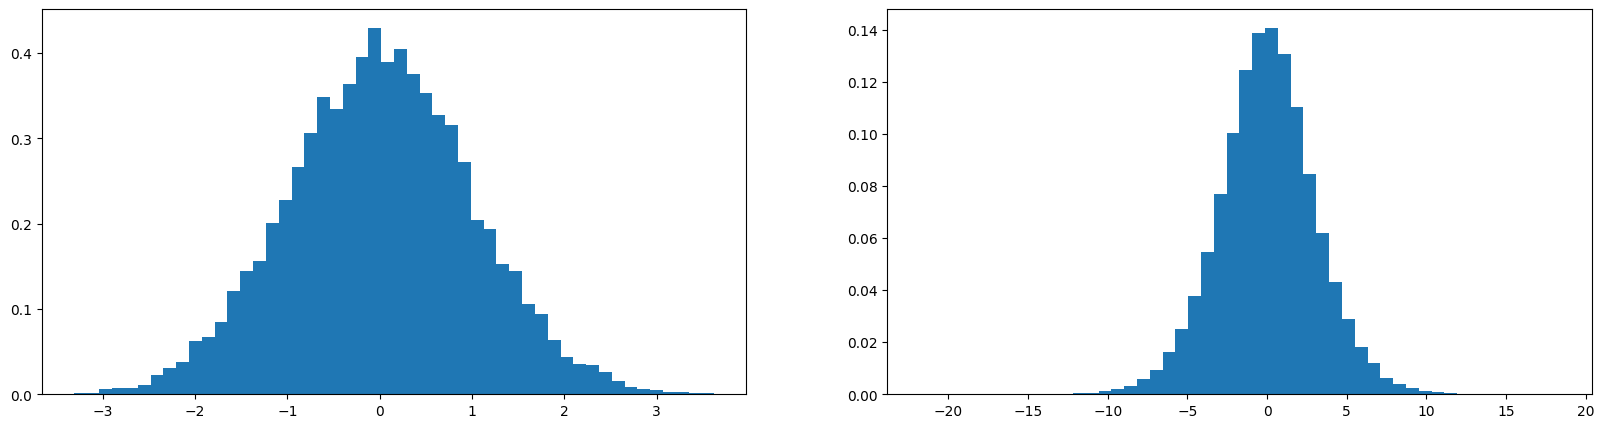

In [47]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y=x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
_ = plt.hist(y.view(-1).tolist(), 50, density=True);

When a gaussian input is multiplied by randomly initialized weights, the output is not a guassian anymore. It still has a mean of zero, but its standard devitions has increased.

<pre>
tensor(-0.0276) tensor(0.9942) <- input
tensor(-0.0105) tensor(3.2512) <- output
</pre>

We want most of the neural net to have roughly similar activations. So the question is, how do we scale the weights to preserve the gaussian output?

Lets multiply the weights by five `w = torch.randn(10, 200) * 5`:

The input and the output becomes:

<pre>
tensor(-0.0124) tensor(1.0053)
tensor(0.0279) tensor(15.9336)
</pre>

With  `w = torch.randn(10, 200) * 0.2`:

<pre>
tensor(0.0022) tensor(0.9950)
tensor(0.0012) tensor(0.6430)
</pre>

So the question is, how do we choose the scaling factors for the weights?

For a simple linear layer, divide by a square root of fan in (the input featueres). With such weight initializaition, for a raughly guassian input, the output will also be roughly gaussian.

For non linearities, you need to compensate for the discarded part of the distribution, so you also need a gain which depends ont he non linearity used. The scaling factor is basically ```gain/sqrt(fanin)```

For more details, refer to the Kaiming initialization paper on arXiv: https://arxiv.org/abs/1502.01852

Now the initalization of the weights for the preactivation function is:

```
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 * (n_embd * block_size)**-0.5
```

In [29]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 * (n_embd * block_size)**-0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation 

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())

11897
      0/ 200000: 3.7971
  10000/ 200000: 2.2270
  20000/ 200000: 2.2422
  30000/ 200000: 2.2745
  40000/ 200000: 2.0341
  50000/ 200000: 1.7015
  60000/ 200000: 2.2676
  70000/ 200000: 2.0063
  80000/ 200000: 2.2954
  90000/ 200000: 2.4001
 100000/ 200000: 1.8561
 110000/ 200000: 2.0723
 120000/ 200000: 1.8639
 130000/ 200000: 1.8688
 140000/ 200000: 1.9298
 150000/ 200000: 2.3193
 160000/ 200000: 2.0602
 170000/ 200000: 2.2118
 180000/ 200000: 2.0626
 190000/ 200000: 2.0679


Initial losses with softmax confidently wrong (random weight initialization without scaling):
<pre>
train 2.119840145111084
val 2.162057399749756
</pre>

After fixing softmax initially confidently wrong:
<pre>
train 2.069589138031006
val 2.131074905395508
</pre>

Fixing tanh too saturated at initialization:
<pre>
train 2.0355966091156006
val 2.102678060531616
</pre>

With kaiming intialization:
<pre>
train 2.0410633087158203
val 2.1087684631347656
</pre>

With Kaiming initialization we got to the same spot that we were at with magic numbers in a semi-structured way.

# Batch Normalization

Another way of normalizing the outputs of the layers is batch normalization, which is esentially used to control the statistics of the activations.

We want `hpreact` to be roughly gaussian - not to big to avoide the saturated space and not to small to avoid the linear part of tanh, which makes it inactive.

We can simply take the pre activations for the entire batch and normalize them.

However, we only want the preactivations to be normal gaussian at initialization. Then we want the neural net to be able to adjust the distribution during backpropagation. For this, we include learnable scale and shift parameters:

```
bngain = torch.ones(n_hidden)
bnbias = torch.zeros(n_hidden)
```

The benefit of batchnorm is that for very deep neural nets, settting the right scaling factors during initialization becomes intractable. With explicit form of normalization (batch norm) this is done automatically. 

It is common to include batch normalizatioin after layers with multiplications, such as linear layers or convolutional layers, to control the scale of activations without manual mathematics.

When using batch normalization, adding the bias to the layer being normalized is a wasteful operation, because in the end it will be removed during the normalization and added back again (in form of the learnable parameter).

So this line:
`hpreact = embcat @ W1 + b1 # hidden layer pre-activation` 
will become:
`hpreact = embcat @ W1 # hidden layer pre-activation` 

With small batch sizes, the stats might change significantly from iteration to iteration. Since the value is chaning aournd a lot, you dont want to take too much from any particular batch. Instead, you want to have large smooting, so the momentum should be kept low. With large batch sizes, it might be safe to keep the momentum relativlely high.

Batch normalization provides stability in neural networks, but at a cost. This cost involves a fundamental change in how neural networks process data. Originally, neural networks processed single examples deterministically. Batches were later introduced for training efficiency, but examples were still processed independently. Batch normalization couples examples within a batch mathematically. This coupling occurs in both forward and backward passes of the neural network.

Hidden state activations and logits for any input example now depend on the input example itself and all other examples in the batch. This leads to subtle changes or "jittering" in activations based on batch composition.

This "jittering" effect, initially seeming like a bug, turns out to be beneficial, because it acts as a regularizer for the neural network. The process introduces entropy into the system, acting as a form of data augmentation and making it harder for the neural network to overfit specific examples.

In [34]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 * (n_embd * block_size)**-0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros(n_hidden)
bnstd_running = torch.zeros(n_hidden)
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad(): # keeo the running stats
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())

12097
      0/ 200000: 3.4858
  10000/ 200000: 2.4437
  20000/ 200000: 2.1583
  30000/ 200000: 2.4405
  40000/ 200000: 2.3218
  50000/ 200000: 1.6986
  60000/ 200000: 2.2350
  70000/ 200000: 2.2101
  80000/ 200000: 1.8826
  90000/ 200000: 1.9384
 100000/ 200000: 1.9418
 110000/ 200000: 1.8950
 120000/ 200000: 2.2382
 130000/ 200000: 1.9526
 140000/ 200000: 2.3795
 150000/ 200000: 1.8391
 160000/ 200000: 1.9638
 170000/ 200000: 2.0640
 180000/ 200000: 2.0253
 190000/ 200000: 1.9956


In [35]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split, mean, std):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = x @ W1 + b1
  hpreact = bngain * (hpreact - mean) / std + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [36]:
with torch.no_grad():
    emb = C[Xtr]
    x = emb.view(emb.shape[0], -1)
    hpreact = x @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [37]:
print('running mean and std')
split_loss('train', bnmean_running, bnstd_running)
split_loss('val', bnmean_running, bnstd_running)

print('mean and std of all data')
split_loss('train', bnmean, bnstd)
split_loss('val', bnmean, bnstd)



running mean and std
train 2.0691652297973633
val 2.1119089126586914
mean and std of all data
train 2.0692460536956787
val 2.111602306365967


Initial losses with softmax confidently wrong (random weight initialization without scaling):
<pre>
train 2.119840145111084
val 2.162057399749756
</pre>

After fixing softmax initially confidently wrong:
<pre>
train 2.069589138031006
val 2.131074905395508
</pre>

Fixing tanh too saturated at initialization:
<pre>
train 2.0355966091156006
val 2.102678060531616
</pre>

With kaiming intialization:
<pre>
train 2.0376644134521484
val 2.106989622116089
</pre>

With batchnorm (and all previous improvements):
<pre>
train 2.0692460536956787
val 2.111602306365967
</pre>

With batchnorm and running means:
<pre>
train 2.0691652297973633
val 2.1119089126586914
</pre>

# More advanced diagnostics

In [273]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in)**0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        self.out = (x - xmean) / (xvar + self.eps).sqrt()
        self.out = self.out * self.gamma + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

def initialize_parameters(n_layers = 6, tanh = True, bn = False, bnOutput = False, output_scale = 0.1, hidden_gain = 5/3):
    C = torch.randn((vocab_size, n_embd), generator=g)
    layers = []

    for i in range(n_layers):
        if i == 0:
            layers.append(Linear(n_embd * block_size, n_hidden, bias=not bn))
        elif i == n_layers - 1:
            layers.append(Linear(n_hidden, vocab_size, bias=not bnOutput))
        else:
            layers.append(Linear(n_hidden, n_hidden, bias=not bn))

        if bn and i < n_layers - 1:
            layers.append(BatchNorm1d(n_hidden))
        if tanh and i < n_layers - 1:
            layers.append(Tanh())

    if bnOutput:
        layers.append(BatchNorm1d(vocab_size))

    with torch.no_grad():
        # last layer: make less confident
        if bnOutput:
            layers[-1].gamma *= output_scale
        else:
            layers[-1].weight *= output_scale
        # all other layers: apply gain
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= hidden_gain

    parameters = [C] + [p for layer in layers for p in layer.parameters()]
    print(sum(p.nelement() for p in parameters)) # number of parameters in total
    for p in parameters:
        p.requires_grad = True

    return C, layers, parameters


In [348]:
def train(breakpoint = 0, lr=0.1):
  # same optimization as last time
  max_steps = 200000
  batch_size = 32
  lossi = []
  ud = []

  for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
      x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
      layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
      p.grad = None
    loss.backward()
    
    # update
    learning_rate = lr if i < 150000 else lr/10 # step learning rate decay
    for p in parameters:
      p.data += -learning_rate * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
      ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) # the log of the ratio of the std of the update and the std of the parameter (the log is for better visibility) and .item to get the float value
    if breakpoint == i:
      break
  return lossi, ud

In [300]:
def visualize_activations_distribution(layers, layer_type = Tanh):
  # visualize historgams for the forward pass
  plt.figure(figsize=(20, 4)) # width and height of the plot
  legends = []
  for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, layer_type):
      t = layer.out
      print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
      hy, hx = torch.histogram(t, density=True)
      plt.plot(hx[:-1].detach(), hy.detach())
      legends.append(f'layer {i} ({layer.__class__.__name__}')
  plt.legend(legends);
  plt.title('activation distribution')

46497
      0/ 200000: 3.2963
layer 1 (      Tanh): mean +0.06, std 0.75, saturated: 20.28%
layer 3 (      Tanh): mean -0.00, std 0.70, saturated: 10.81%
layer 5 (      Tanh): mean +0.03, std 0.67, saturated: 7.72%
layer 7 (      Tanh): mean -0.07, std 0.64, saturated: 5.59%
layer 9 (      Tanh): mean -0.05, std 0.65, saturated: 5.69%


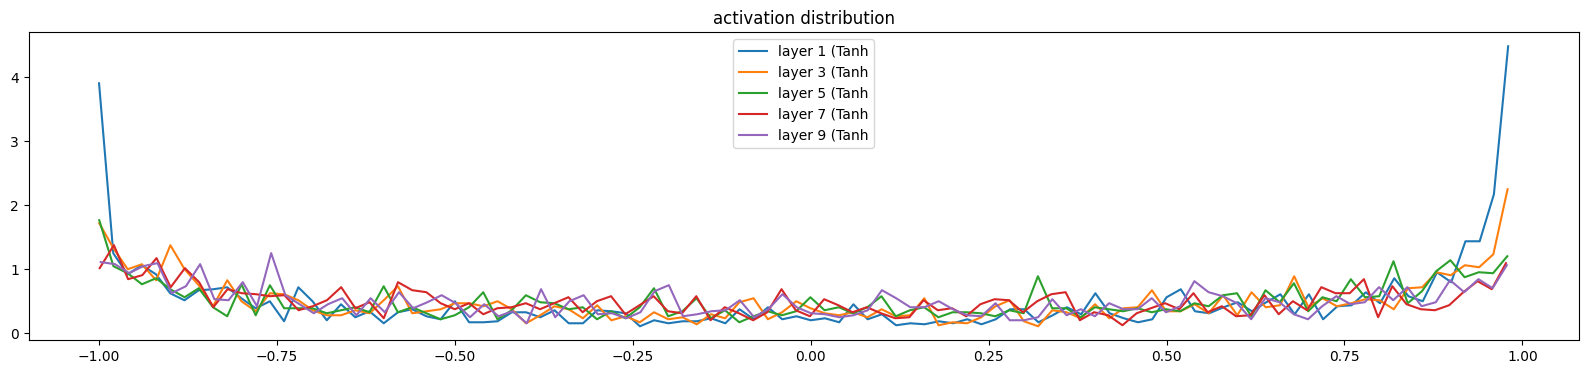

In [316]:
C, layers, parameters = initialize_parameters()
lossi, ud = train()
visualize_activations_distribution(layers)

Most of the layers are not saturated, thanks to the 5/3 gain which adjusts the preactivations accordingly. With even more layers the standard deviation would stabilize at around 0.65 and the saturation would be around 5%.

46497
      0/ 200000: 3.3002
layer 1 (      Tanh): mean -0.02, std 0.59, saturated: 1.84%
layer 3 (      Tanh): mean -0.01, std 0.47, saturated: 0.03%
layer 5 (      Tanh): mean +0.01, std 0.39, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.34, saturated: 0.00%
layer 9 (      Tanh): mean +0.01, std 0.30, saturated: 0.00%


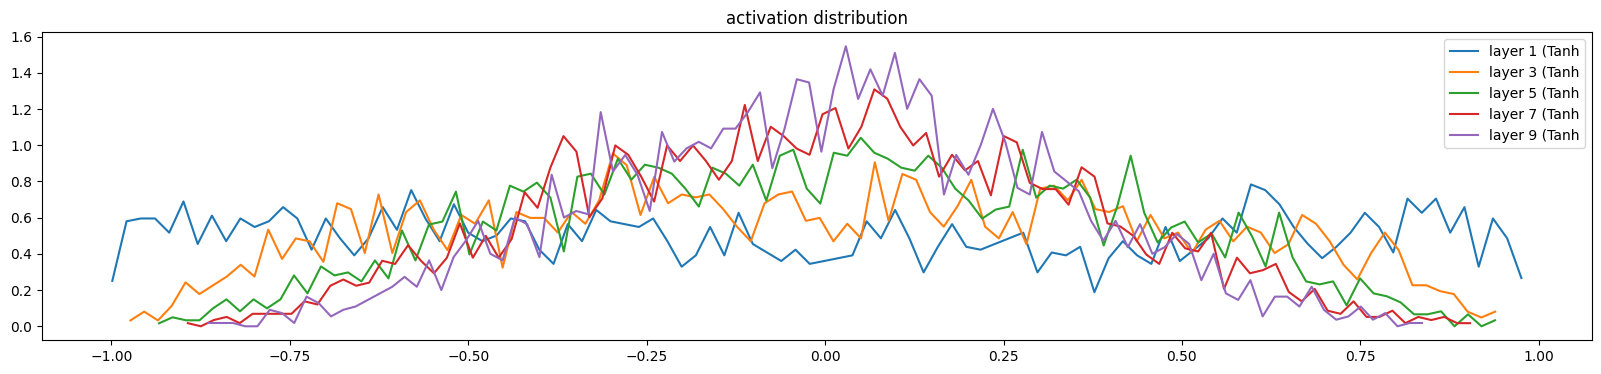

In [294]:
C, layers, parameters = initialize_parameters(hidden_gain=1)
lossi, ud = train()
visualize_activations_distribution(layers)

With an improper agin the saturation is shrinking and the standard deviation is coming to zero. The deeper the layer, the smaller the standard deviation.

With a neural network composed of linear layers alone, vanila Kaiming initialization (without extra gain) will presevre the standard deviation of one. But the intersperesed layers of tanh are squashing functions - they take the input distribution and they keep squashing it, reducing the standard deviation slowly over the depth of the network. So the gain of 5/3 is required to counteract the squashing of the tanh function.

The reason why the saturation is low even without the gain is because the vanila Kaiming initialization alone improves the distribution of the pre activations significantly.

46497
      0/ 200000: 3.2798
layer 1 (      Tanh): mean -0.03, std 0.87, saturated: 49.47%
layer 3 (      Tanh): mean +0.06, std 0.84, saturated: 42.03%
layer 5 (      Tanh): mean -0.01, std 0.84, saturated: 40.53%
layer 7 (      Tanh): mean +0.03, std 0.84, saturated: 39.25%
layer 9 (      Tanh): mean -0.01, std 0.84, saturated: 40.19%


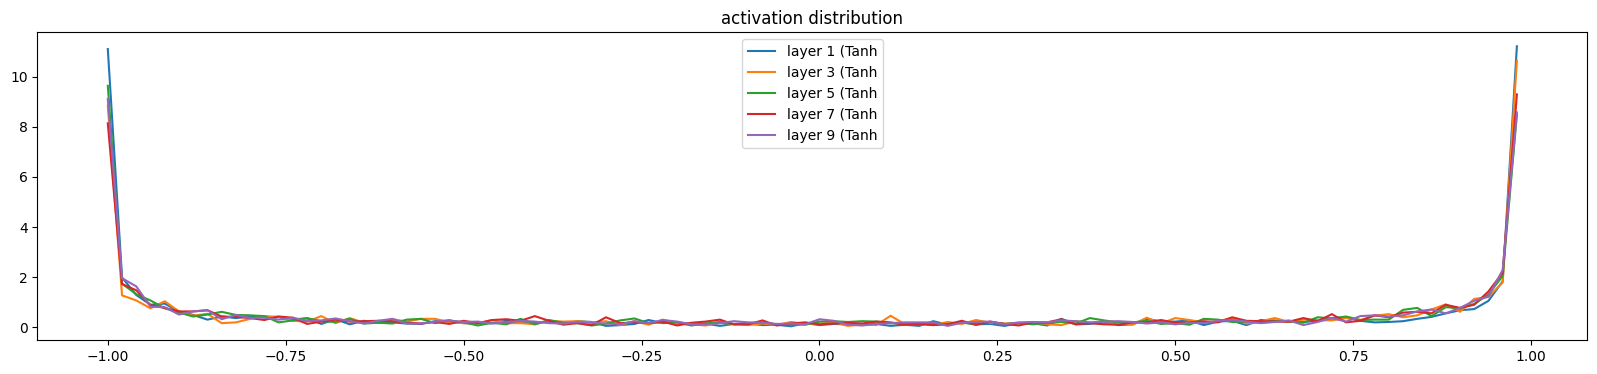

In [295]:
C, layers, parameters = initialize_parameters(hidden_gain=3)
lossi, ud = train()
visualize_activations_distribution(layers)

With too large of a gain the saturation now is messed up. We need to balance the two - the standard deviation of the activations and the saturation of the activations. 5/3 is a good setting for linear layers with tanh activations, and it roughly stabilizes the stds of activations at a reasonable point. 

In [301]:
def visualize_gradients_distribution(layers, layer_type = Tanh):
  # visualize histograms
  plt.figure(figsize=(20, 4)) # width and height of the plot
  legends = []
  for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, layer_type):
      t = layer.out.grad
      print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
      hy, hx = torch.histogram(t, density=True)
      plt.plot(hx[:-1].detach(), hy.detach())
      legends.append(f'layer {i} ({layer.__class__.__name__}')
  plt.legend(legends);
  plt.title('gradient distribution')

46497
      0/ 200000: 3.3025
layer 1 (      Tanh): mean -0.000001, std 3.849001e-04
layer 3 (      Tanh): mean -0.000002, std 3.931220e-04
layer 5 (      Tanh): mean +0.000002, std 3.758481e-04
layer 7 (      Tanh): mean +0.000001, std 3.406524e-04
layer 9 (      Tanh): mean +0.000002, std 3.016355e-04


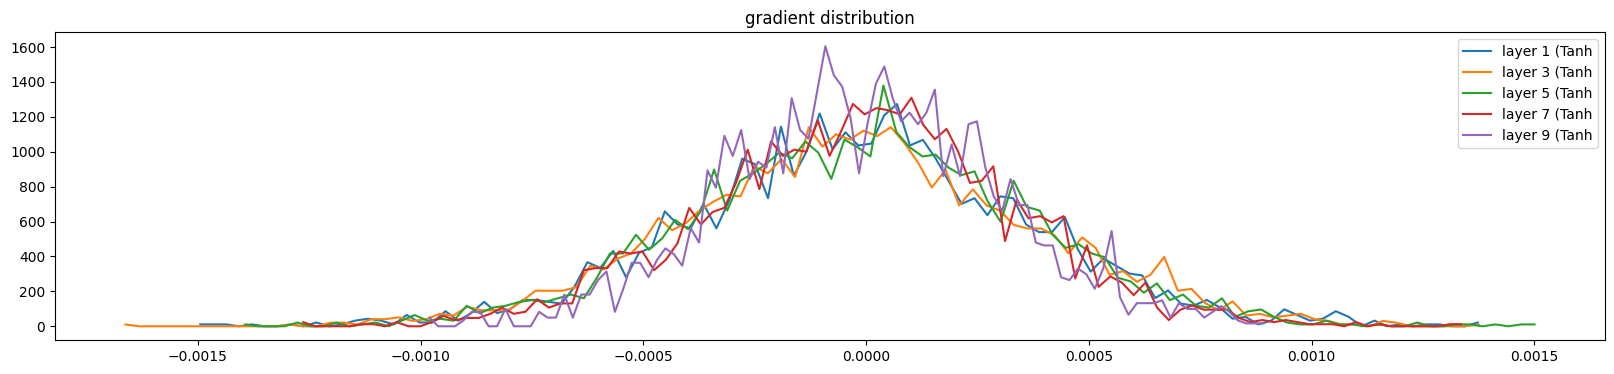

In [296]:
C, layers, parameters = initialize_parameters()
lossi, ud = train()
visualize_gradients_distribution(layers)

What we are looking for is that all the layers have roughly the same gradients - things are not shrinking or exploding. When the gain is too small the values will be squashed more and more in the deeper layers. So for the deeper layers the mean will be still zero, but the standard deviation will be smaller. This means that for the deeper layers the gradients will be larger, because the activations will be in the non flat region of the tanh function.

When the gain is too large, the deeper layers will have higher standard deviation and their gradients will be lower. In any case, with improperly calibrated gain, there will be assymetry in how the layers in the network are learning.

46497
      0/ 200000: 3.2958
layer 1 (      Tanh): mean -0.000000, std 1.732553e-05
layer 3 (      Tanh): mean +0.000000, std 3.702601e-05
layer 5 (      Tanh): mean -0.000002, std 7.464267e-05
layer 7 (      Tanh): mean -0.000002, std 1.530062e-04
layer 9 (      Tanh): mean -0.000010, std 3.058125e-04


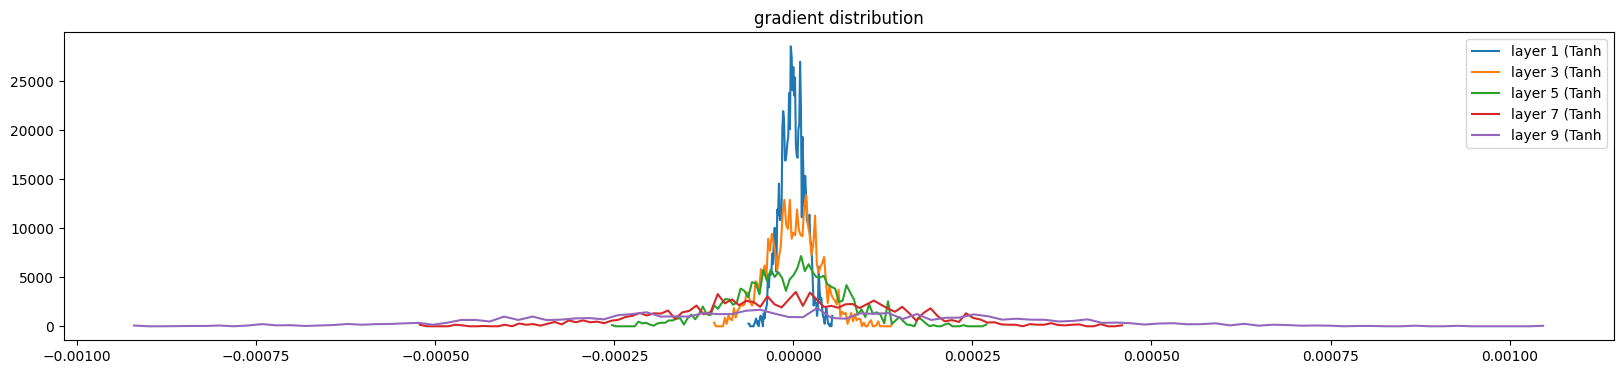

In [283]:
C, layers, parameters = initialize_parameters(hidden_gain=0.5)
lossi, ud = train()
visualize_gradients_distribution(layers)

46497
      0/ 200000: 3.2990
layer 1 (      Tanh): mean +0.000005, std 1.151790e-03
layer 3 (      Tanh): mean +0.000008, std 8.454103e-04
layer 5 (      Tanh): mean +0.000007, std 6.250885e-04
layer 7 (      Tanh): mean +0.000021, std 4.423975e-04
layer 9 (      Tanh): mean -0.000006, std 3.138811e-04


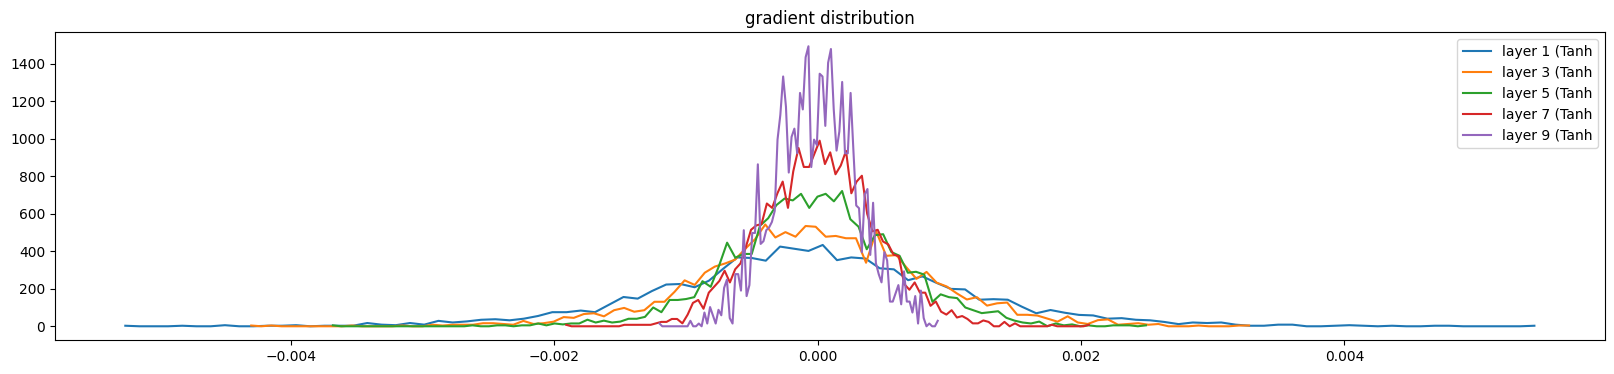

In [285]:
C, layers, parameters = initialize_parameters(hidden_gain=3)
lossi, ud = train()
visualize_gradients_distribution(layers)

Things will look good with the following setting:

46497
      0/ 200000: 3.3003
activations:
layer 1 (      Tanh): mean +0.05, std 0.76, saturated: 22.00%
layer 3 (      Tanh): mean -0.01, std 0.68, saturated: 8.38%
layer 5 (      Tanh): mean +0.03, std 0.66, saturated: 6.66%
layer 7 (      Tanh): mean -0.02, std 0.66, saturated: 5.00%
layer 9 (      Tanh): mean -0.03, std 0.66, saturated: 7.22%
gradients:
layer 1 (      Tanh): mean -0.000005, std 4.175472e-04
layer 3 (      Tanh): mean +0.000007, std 3.864900e-04
layer 5 (      Tanh): mean -0.000011, std 3.472029e-04
layer 7 (      Tanh): mean -0.000009, std 3.205926e-04
layer 9 (      Tanh): mean -0.000005, std 3.034213e-04


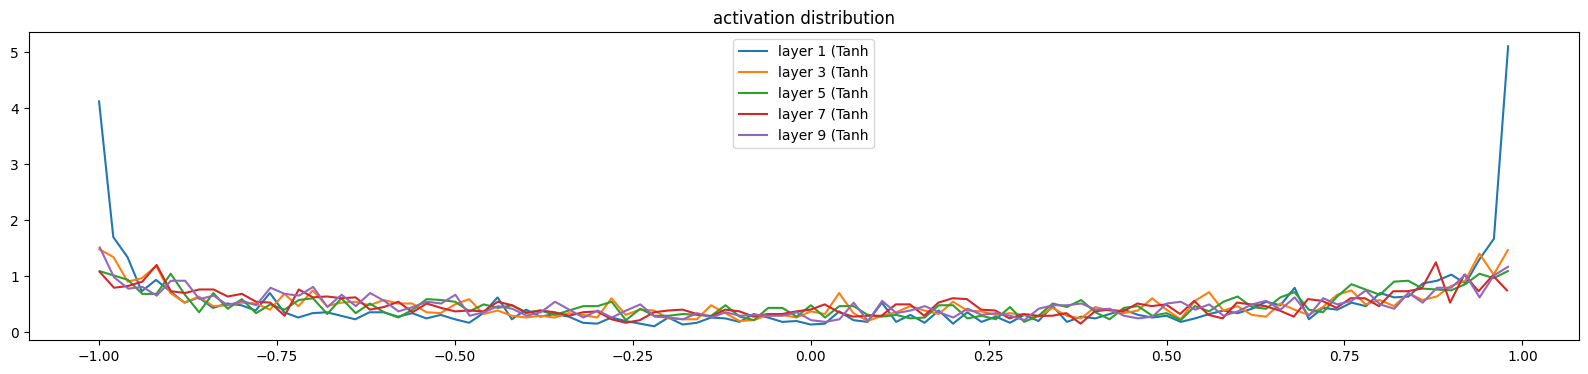

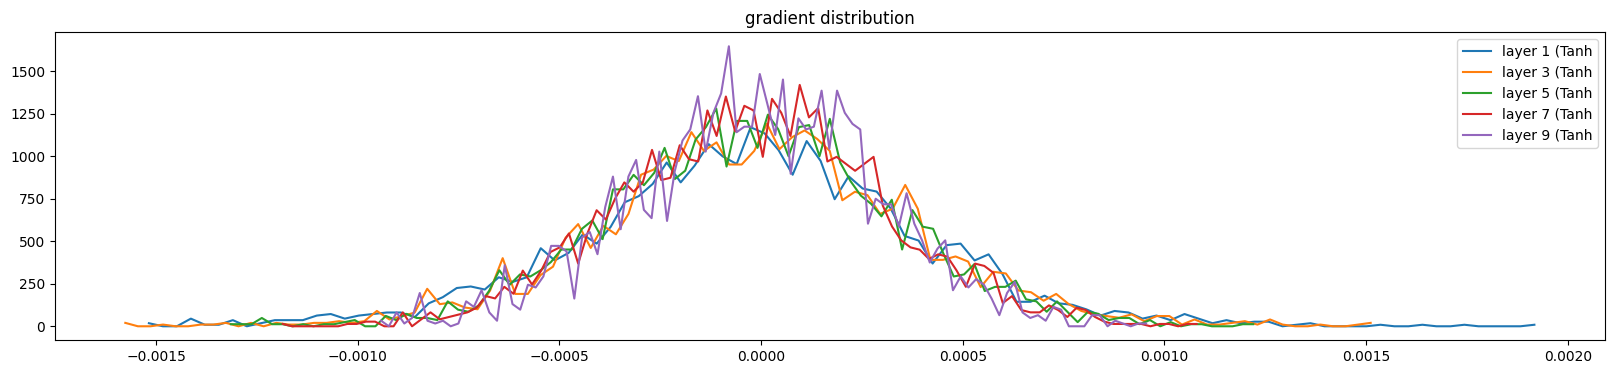

In [297]:
C, layers, parameters = initialize_parameters(hidden_gain=5/3)
lossi, ud = train()
print("activations:")
visualize_activations_distribution(layers)
print("gradients:")
visualize_gradients_distribution(layers)

Now, what happens when the non linearities, the tanh functions, are removed, but the gain is kept at 5/3?

46497
      0/ 200000: 4.0988
activations:
layer 0 (    Linear): mean +0.07, std 1.60, saturated: 54.22%
layer 1 (    Linear): mean +0.12, std 2.72, saturated: 71.38%
layer 2 (    Linear): mean -0.09, std 4.52, saturated: 82.56%
layer 3 (    Linear): mean +0.37, std 7.44, saturated: 89.44%
layer 4 (    Linear): mean -0.45, std 12.13, saturated: 92.66%
gradients:
layer 0 (    Linear): mean +0.000051, std 2.454098e-03
layer 1 (    Linear): mean -0.000020, std 1.470238e-03
layer 2 (    Linear): mean -0.000041, std 8.921799e-04
layer 3 (    Linear): mean +0.000014, std 5.405223e-04
layer 4 (    Linear): mean -0.000008, std 3.200969e-04


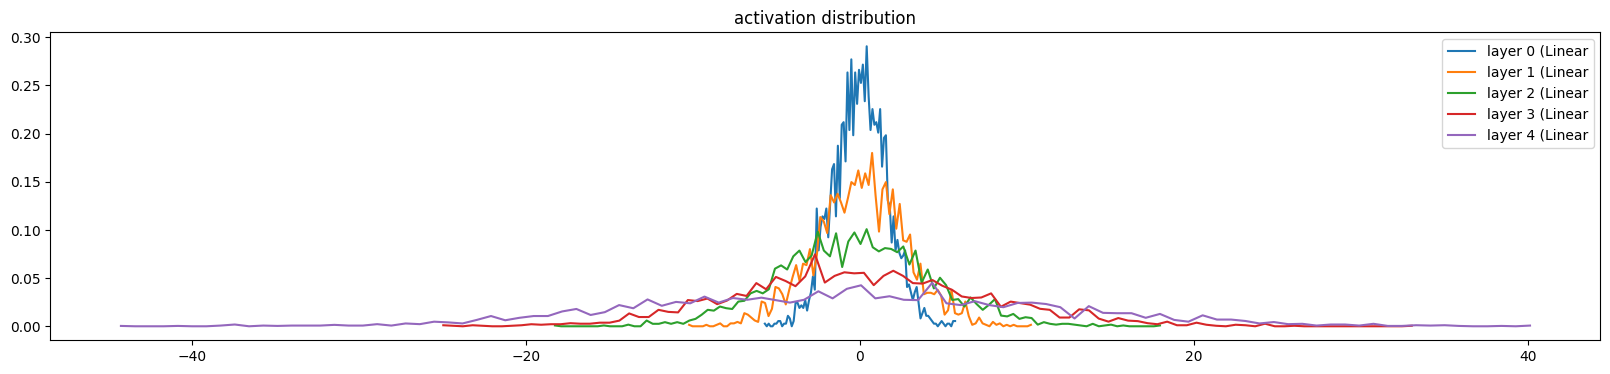

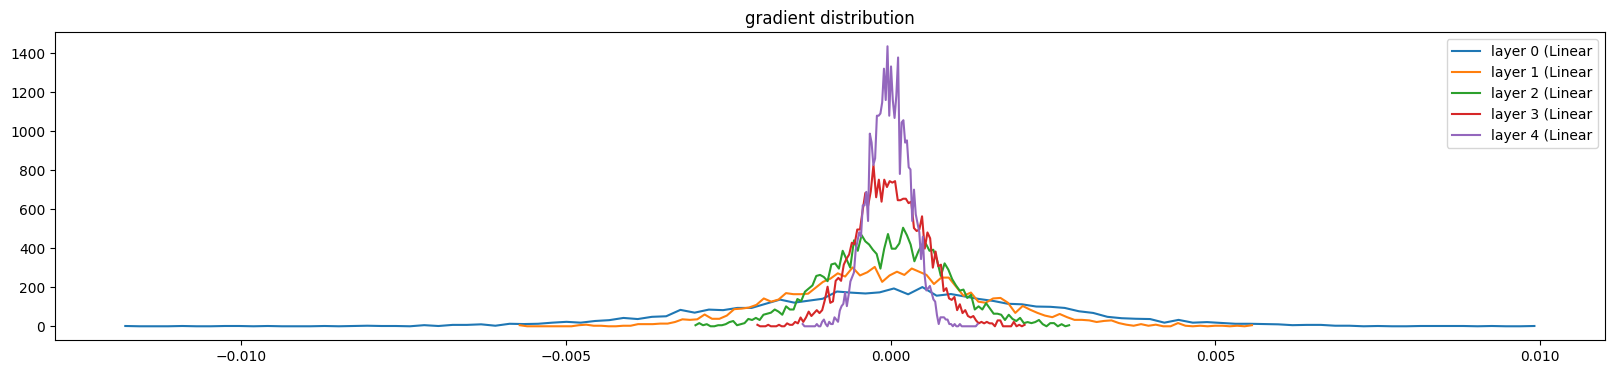

In [303]:
C, layers, parameters = initialize_parameters(tanh=False, hidden_gain=5/3)
lossi, ud = train()
print("activations:")
visualize_activations_distribution(layers, layer_type=Linear)
print("gradients:")
visualize_gradients_distribution(layers, layer_type=Linear)

The activations start with low std and then explode. The gradients behave the other way round - a small change in the input to the first layer changes the output significantly. The gradients diminish as you go deeper, which is not desirable. So if the gain is improperly initialized, basically to small or too low, the gradients and activations will shrink or diffuse. For a stack of linear layers the correct gain is exactly one, which makes everything look nice and smooth:

46497
      0/ 200000: 3.3391
activations:
layer 0 (    Linear): mean -0.01, std 0.92, saturated: 28.47%
layer 1 (    Linear): mean -0.04, std 0.90, saturated: 28.75%
layer 2 (    Linear): mean +0.01, std 0.95, saturated: 30.06%
layer 3 (    Linear): mean +0.01, std 0.94, saturated: 28.44%
layer 4 (    Linear): mean +0.02, std 0.96, saturated: 29.66%
gradients:
layer 0 (    Linear): mean -0.000013, std 3.324432e-04
layer 1 (    Linear): mean +0.000002, std 3.210095e-04
layer 2 (    Linear): mean +0.000012, std 3.126570e-04
layer 3 (    Linear): mean +0.000005, std 3.168843e-04
layer 4 (    Linear): mean -0.000005, std 3.090554e-04


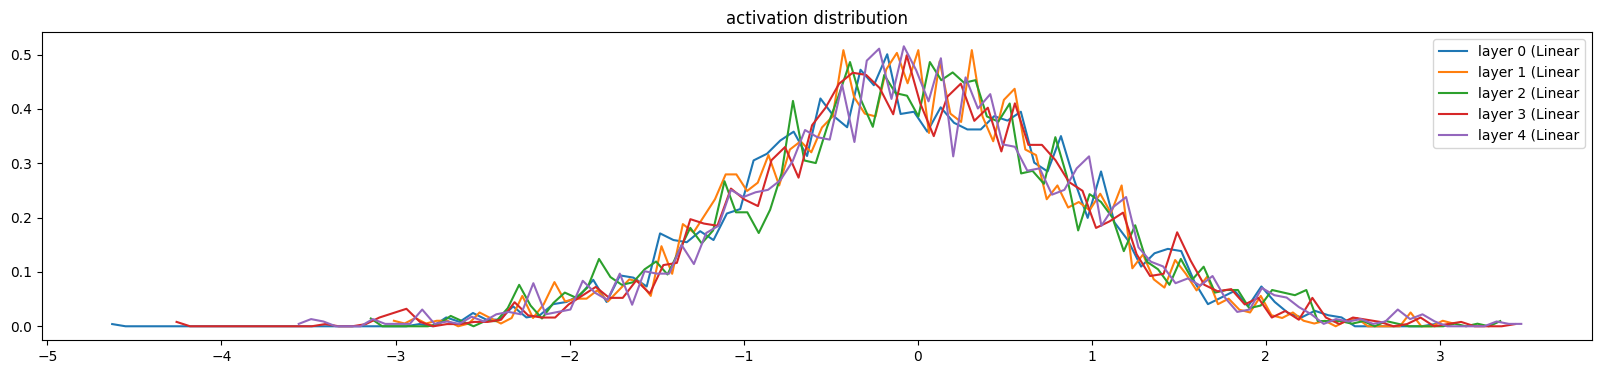

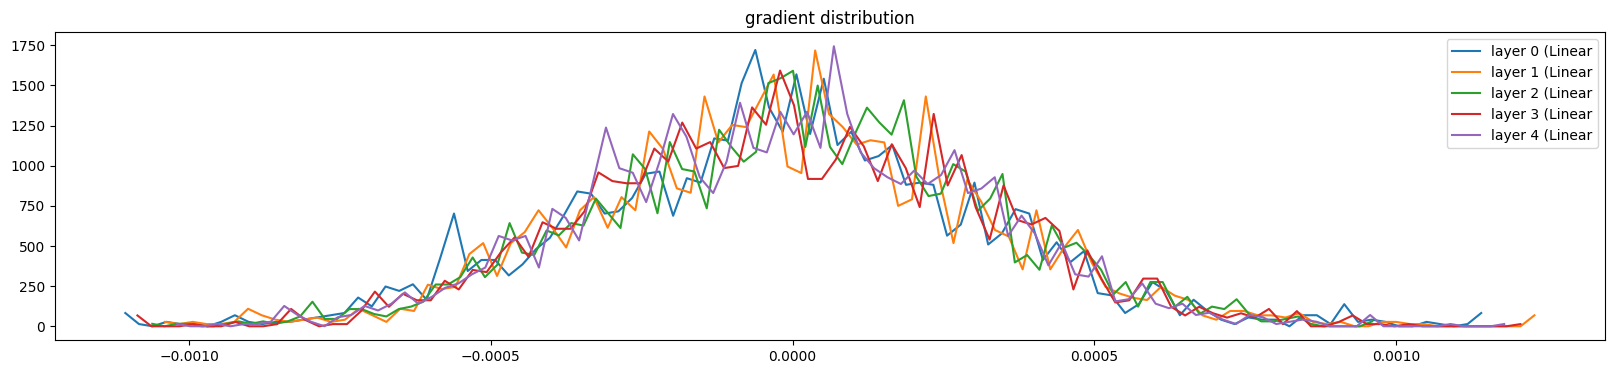

In [304]:
C, layers, parameters = initialize_parameters(tanh=False, hidden_gain=1)
lossi, ud = train()
print("activations:")
visualize_activations_distribution(layers, layer_type=Linear)
print("gradients:")
visualize_gradients_distribution(layers, layer_type=Linear)

In [309]:
def visaulize_weight_distribution(parameters):
  # visualize histograms
  plt.figure(figsize=(20, 4)) # width and height of the plot
  legends = []
  for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
      print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
      hy, hx = torch.histogram(t, density=True)
      plt.plot(hx[:-1].detach(), hy.detach())
      legends.append(f'{i} {tuple(p.shape)}')
  plt.legend(legends)
  plt.title('weights gradient distribution');

46497
      0/ 200000: 3.2977
activations:
layer 1 (      Tanh): mean -0.04, std 0.79, saturated: 27.03%
layer 3 (      Tanh): mean +0.01, std 0.70, saturated: 11.22%
layer 5 (      Tanh): mean -0.02, std 0.67, saturated: 7.53%
layer 7 (      Tanh): mean +0.00, std 0.66, saturated: 6.69%
layer 9 (      Tanh): mean +0.02, std 0.65, saturated: 5.44%
gradients:
layer 1 (      Tanh): mean +0.000005, std 3.922764e-04
layer 3 (      Tanh): mean -0.000010, std 3.863154e-04
layer 5 (      Tanh): mean -0.000005, std 3.597796e-04
layer 7 (      Tanh): mean -0.000006, std 3.167514e-04
layer 9 (      Tanh): mean +0.000004, std 3.017114e-04
updates:
weight   (27, 10) | mean -0.000000 | std 1.137705e-03 | grad:data ratio 1.062409e-03
weight  (30, 100) | mean +0.000014 | std 1.287735e-03 | grad:data ratio 4.171875e-03
weight (100, 100) | mean -0.000008 | std 1.038519e-03 | grad:data ratio 6.242975e-03
weight (100, 100) | mean -0.000002 | std 8.841471e-04 | grad:data ratio 5.358188e-03
weight (100, 10

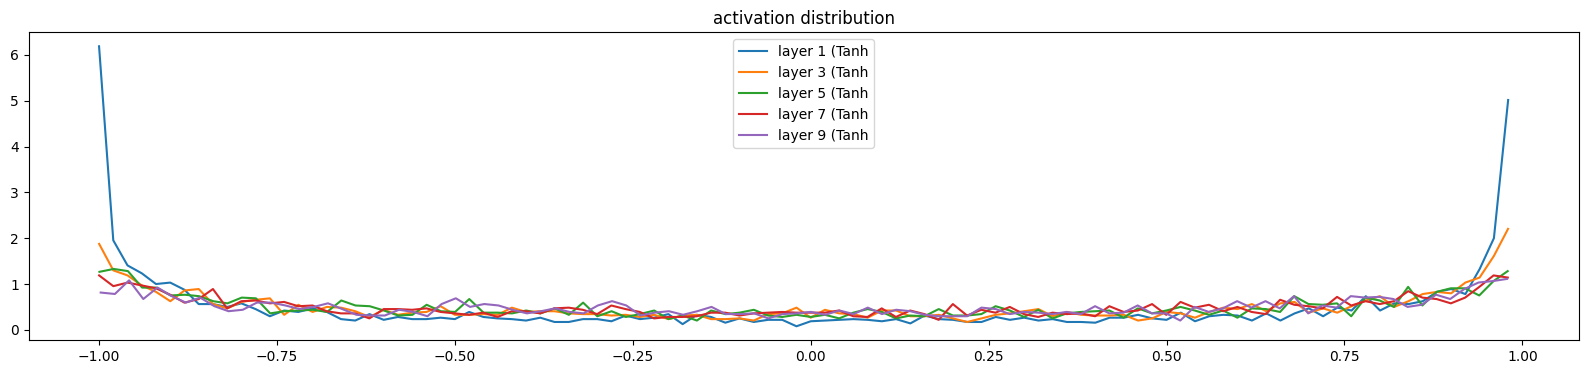

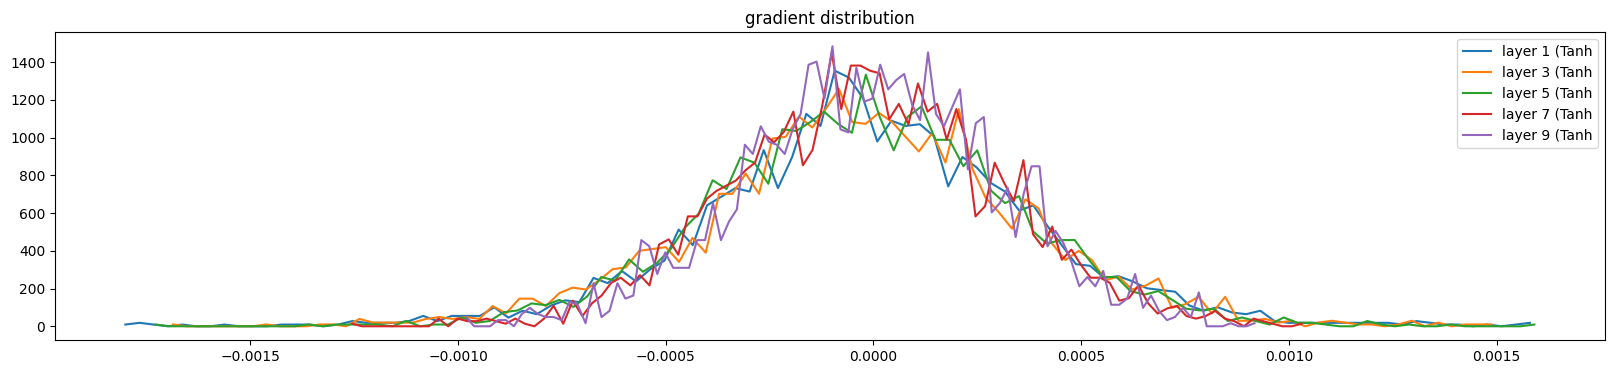

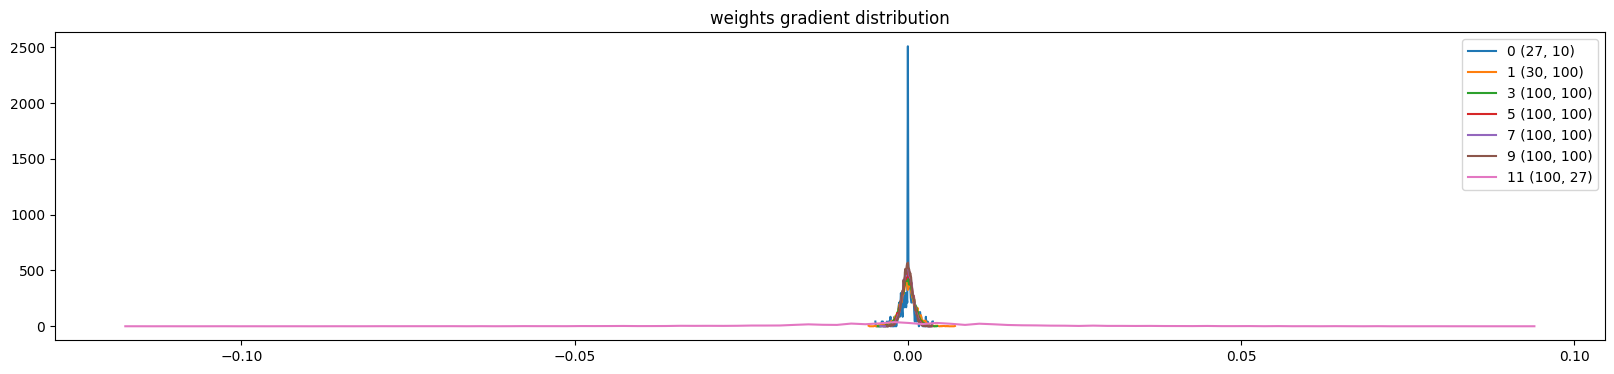

In [310]:
C, layers, parameters = initialize_parameters(tanh=True, hidden_gain=5/3)
lossi, ud = train()
print("activations:")
visualize_activations_distribution(layers)
print("gradients:")
visualize_gradients_distribution(layers)
print("updates:")
visaulize_weight_distribution(parameters)

Gradient to data ratio shows what the scale of the gradient compared to the scale od the actual values is. This is important when doing the step updates to the values of the weights.

The gradients of the weights in the last layer take on way larger values than then the gradients of the hidden layers by around one order of magnitude. This means that at initialization the final layer would be trained around 10 times faster than the hidden layers.

This will slightly improve after we run the training loop for a while.

46497
      0/ 200000: 3.2805
activations:
layer 1 (      Tanh): mean -0.01, std 0.76, saturated: 20.81%
layer 3 (      Tanh): mean -0.03, std 0.72, saturated: 11.09%
layer 5 (      Tanh): mean -0.02, std 0.72, saturated: 10.59%
layer 7 (      Tanh): mean +0.04, std 0.73, saturated: 11.34%
layer 9 (      Tanh): mean +0.06, std 0.71, saturated: 9.81%
gradients:
layer 1 (      Tanh): mean +0.000016, std 2.727671e-03
layer 3 (      Tanh): mean -0.000079, std 2.629300e-03
layer 5 (      Tanh): mean +0.000055, std 2.547292e-03
layer 7 (      Tanh): mean +0.000047, std 2.526189e-03
layer 9 (      Tanh): mean +0.000051, std 2.130061e-03
updates:
weight   (27, 10) | mean +0.000922 | std 9.747148e-03 | grad:data ratio 1.074032e-02
weight  (30, 100) | mean -0.000062 | std 7.989960e-03 | grad:data ratio 2.594206e-02
weight (100, 100) | mean -0.000023 | std 6.241884e-03 | grad:data ratio 3.709761e-02
weight (100, 100) | mean +0.000004 | std 5.816464e-03 | grad:data ratio 3.489199e-02
weight (100, 

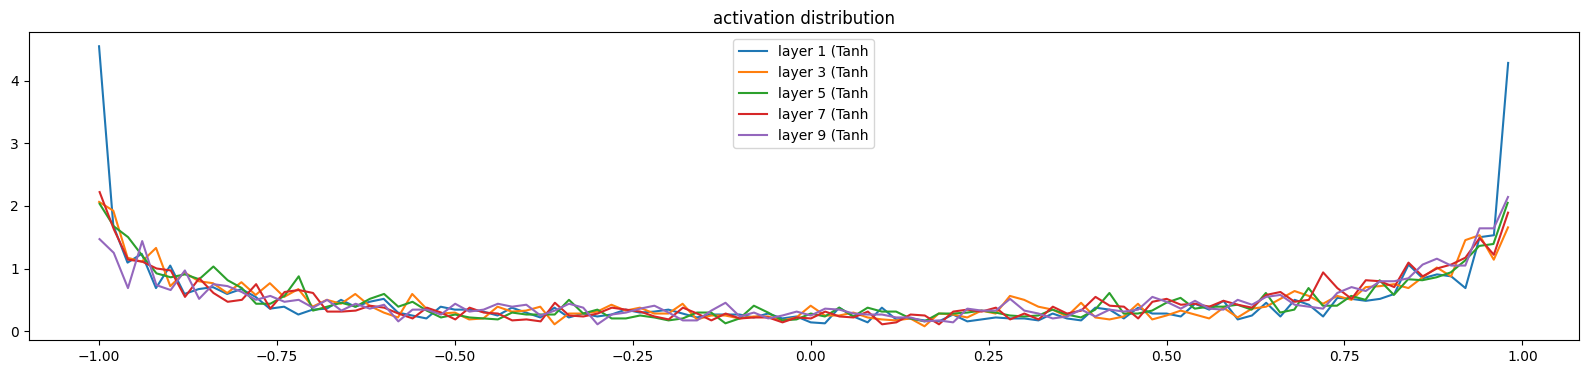

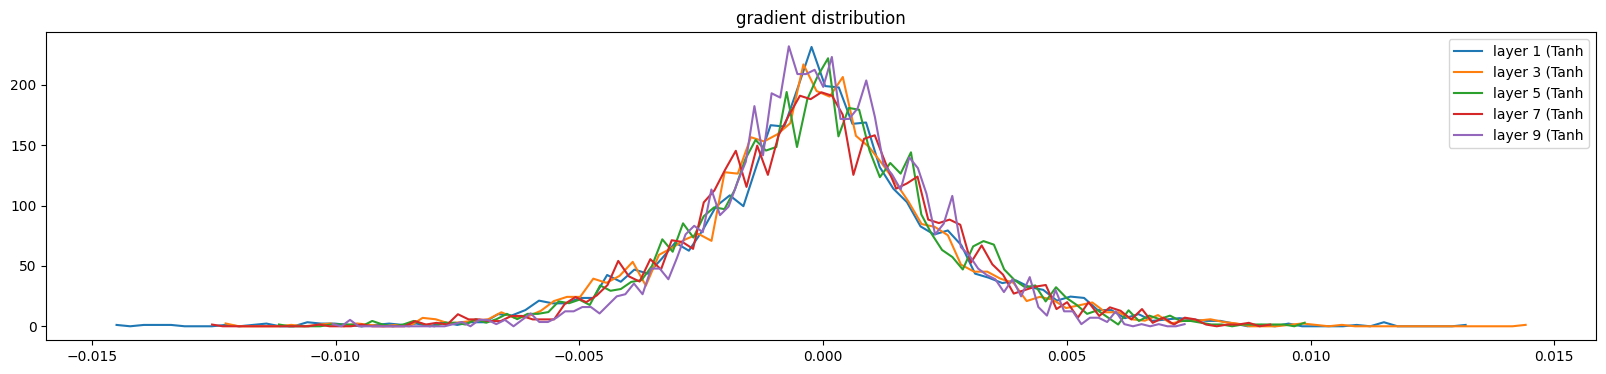

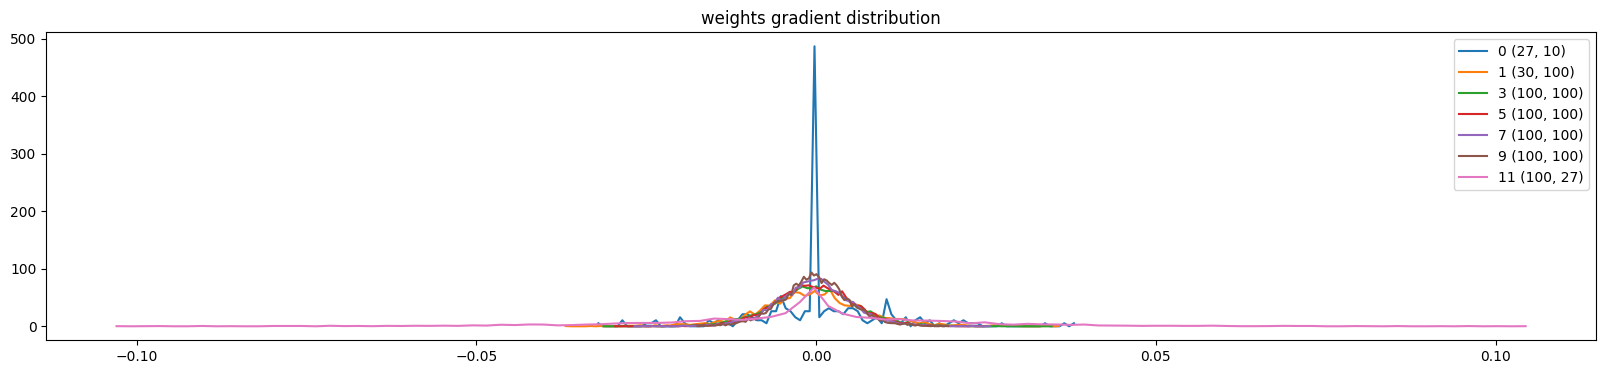

In [318]:
C, layers, parameters = initialize_parameters(tanh=True, hidden_gain=5/3)
lossi, ud = train(breakpoint=1000)
print("activations:")
visualize_activations_distribution(layers)
print("gradients:")
visualize_gradients_distribution(layers)
print("updates:")
visaulize_weight_distribution(parameters)

In [324]:
def visualize_update_to_param_log_ratio(parameters, ud):
  plt.figure(figsize=(20, 4))
  legends = []
  for i,p in enumerate(parameters): # iterate over the parameters W1, b1, W2, b2, C ...
    if p.ndim == 2: # consider only the weight matrices (ignore biases)
      plt.plot([ud[j][i] for j in range(len(ud))]) # plot the update to parameter ratio for each parameter
      legends.append('param %d' % i)
  plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
  plt.legend(legends);

46497
      0/ 200000: 3.2914


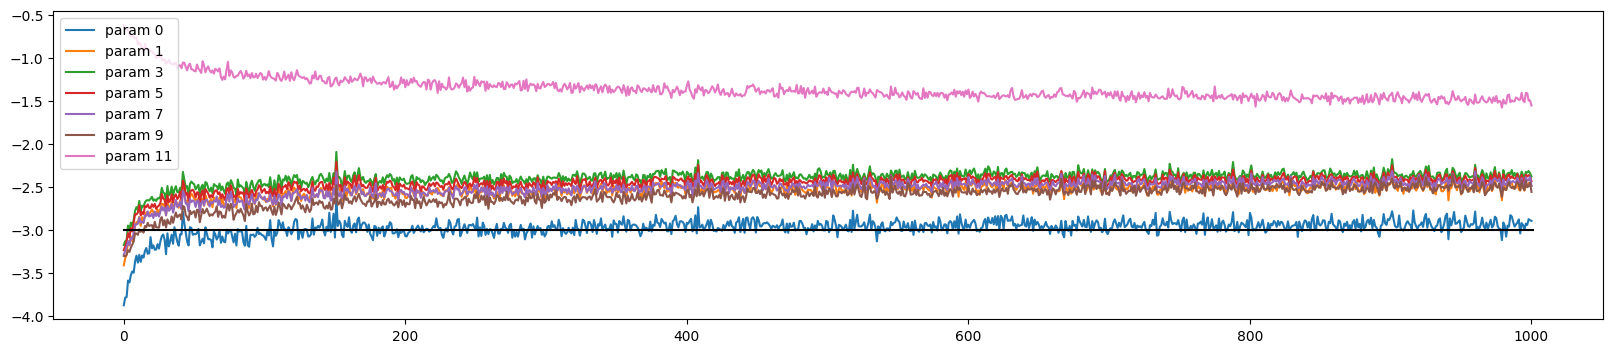

In [327]:
C, layers, parameters = initialize_parameters(tanh=True, hidden_gain=5/3)
lossi, ud = train(breakpoint=1000)
visualize_update_to_param_log_ratio(parameters, ud)

0.001 is a rough, empirically good value of what the log of the parameter update should be (marked with black line on the graph) relative to the actual magnitude of the parameter. That means that the update should be roughly one thousandth of the parameter's (tensor's) magnitude. 

The reason the final layer is an outlier is because it was initially artificially shrunk down to keep the softmax unconfident. That artifiicially made the value in the parameter tensor too low and thats why the ratio was temporarily too high (it can be seen to stabilize later on).

If the lines are below 0.001, it means that the parameters are not trained fast enough. This can be seen when the learning rate is small, for example 0.001.

46497
      0/ 200000: 3.2772


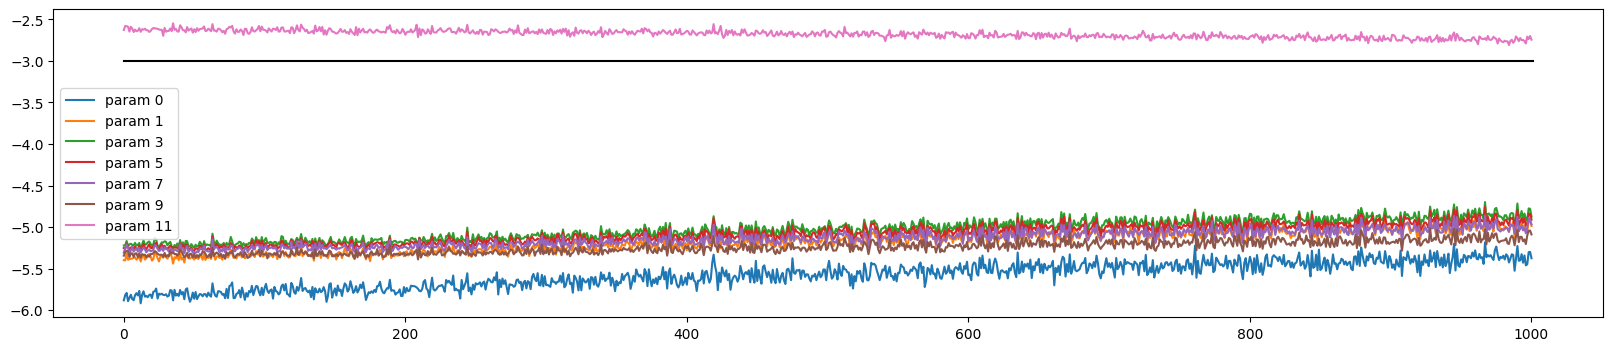

In [329]:
C, layers, parameters = initialize_parameters(tanh=True, hidden_gain=5/3)
lossi, ud = train(breakpoint=1000, lr=0.001)
visualize_update_to_param_log_ratio(parameters, ud)

Example of neural network uncalibration (????). Everything is off:

46497
      0/ 200000: 3.2969
activations:
layer 1 (      Tanh): mean -0.03, std 0.97, saturated: 88.00%
layer 3 (      Tanh): mean +0.03, std 0.97, saturated: 88.41%
layer 5 (      Tanh): mean -0.05, std 0.97, saturated: 87.28%
layer 7 (      Tanh): mean +0.01, std 0.98, saturated: 88.72%
layer 9 (      Tanh): mean +0.01, std 0.97, saturated: 88.56%
gradients:
layer 1 (      Tanh): mean -0.000067, std 1.584804e-02
layer 3 (      Tanh): mean +0.000128, std 5.944745e-03
layer 5 (      Tanh): mean -0.000017, std 1.885429e-03
layer 7 (      Tanh): mean +0.000022, std 7.424915e-04
layer 9 (      Tanh): mean -0.000015, std 3.014200e-04
updates:
weight   (27, 10) | mean -0.002441 | std 2.254547e-01 | grad:data ratio 2.514181e-01
weight  (30, 100) | mean +0.001060 | std 1.669870e-02 | grad:data ratio 6.146673e-03
weight (100, 100) | mean -0.000080 | std 6.484010e-03 | grad:data ratio 4.317544e-03
weight (100, 100) | mean -0.000022 | std 2.264061e-03 | grad:data ratio 1.509356e-03
weight (100,

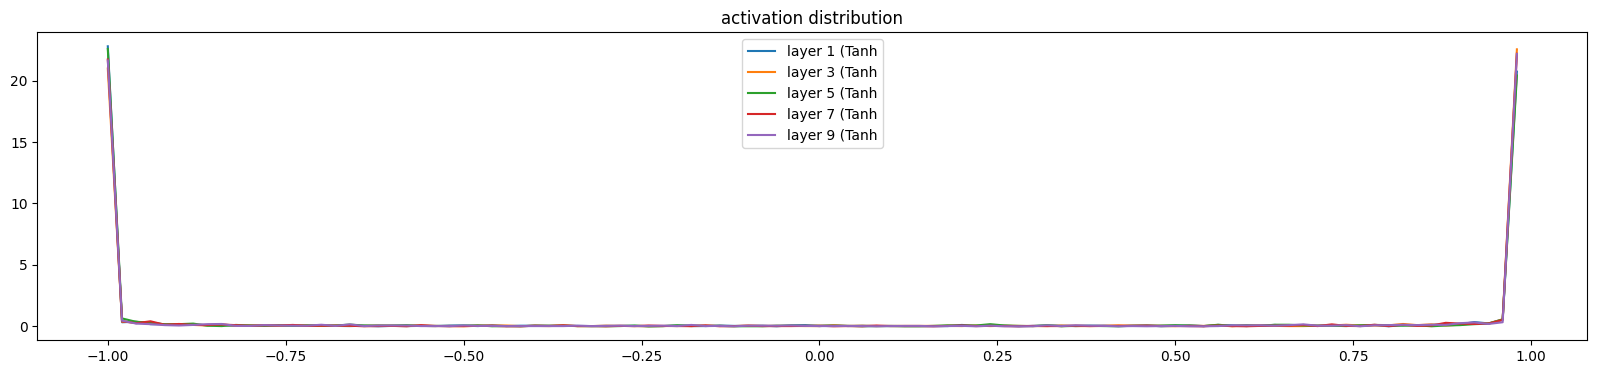

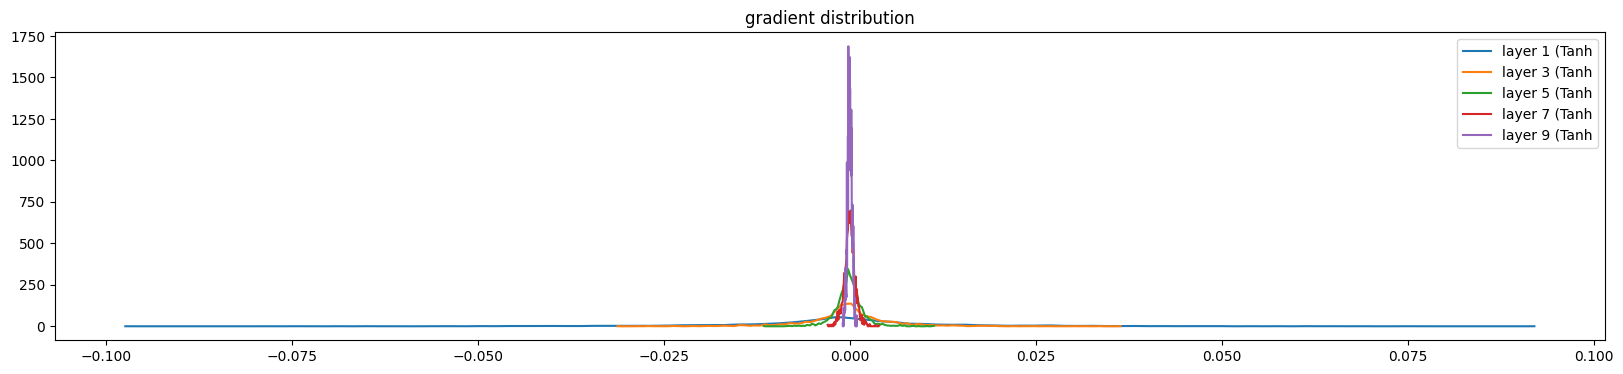

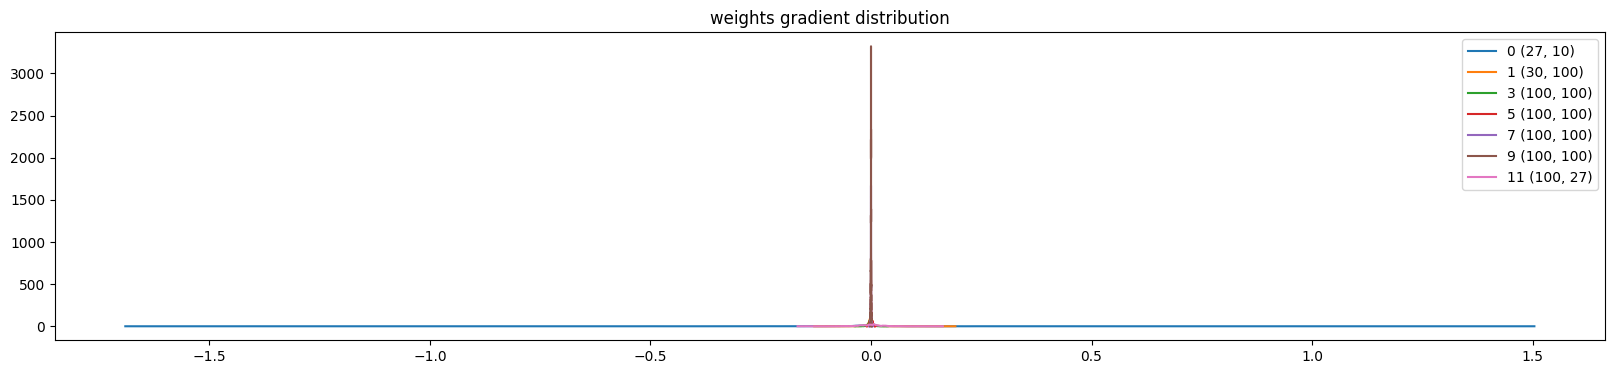

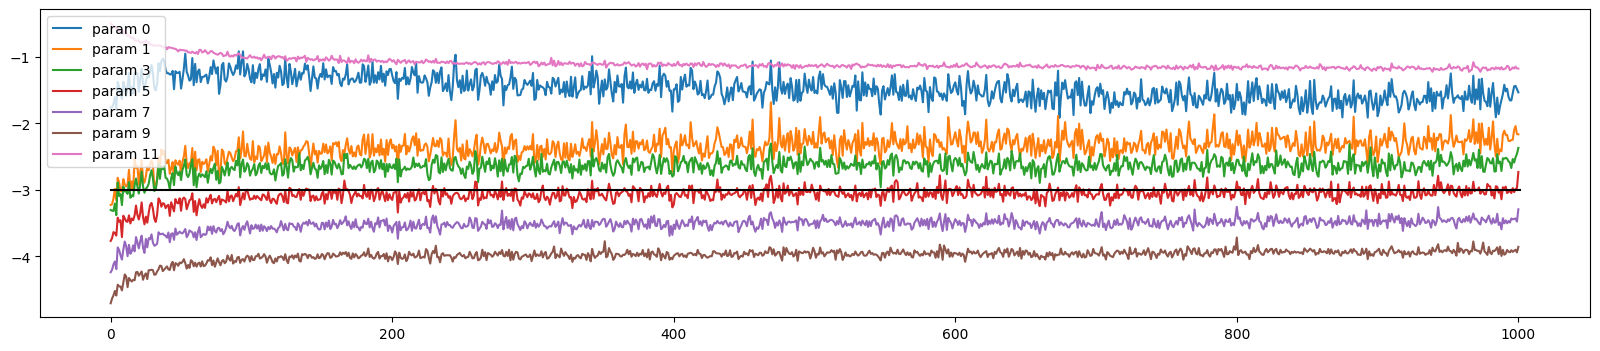

In [333]:
C, layers, parameters = initialize_parameters(tanh=True, hidden_gain=15)
lossi, ud = train(breakpoint=0)
print("activations:")
visualize_activations_distribution(layers)
print("gradients:")
visualize_gradients_distribution(layers)
print("updates:")
visaulize_weight_distribution(parameters)
C, layers, parameters = initialize_parameters(tanh=True, hidden_gain=15)
lossi, ud = train(breakpoint=1000)
print("update to param log ratio (10000 steps):")
visualize_update_to_param_log_ratio(parameters, ud)

So far we have been setting all the gains and scaling factors manually to calibrate the neural net. Introducing batch normalization into the the NN architecture will make everything way easier.

47024
      0/ 200000: 3.3079
activations:
layer 2 (      Tanh): mean -0.01, std 0.62, saturated: 3.47%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 3.09%
layer 8 (      Tanh): mean -0.01, std 0.63, saturated: 2.91%
layer 11 (      Tanh): mean -0.00, std 0.63, saturated: 2.94%
layer 14 (      Tanh): mean +0.00, std 0.63, saturated: 2.50%
gradients:
layer 2 (      Tanh): mean +0.000000, std 8.672252e-04
layer 5 (      Tanh): mean -0.000000, std 6.749270e-04
layer 8 (      Tanh): mean +0.000000, std 5.732585e-04
layer 11 (      Tanh): mean +0.000000, std 5.092327e-04
layer 14 (      Tanh): mean +0.000000, std 4.769767e-04
updates:
weight   (27, 10) | mean -0.000000 | std 2.110815e-03 | grad:data ratio 1.974278e-03
weight  (30, 100) | mean +0.000056 | std 1.780281e-03 | grad:data ratio 5.885175e-03
weight (100, 100) | mean -0.000004 | std 1.604366e-03 | grad:data ratio 9.753929e-03
weight (100, 100) | mean +0.000005 | std 1.345732e-03 | grad:data ratio 8.074732e-03
weight (100, 

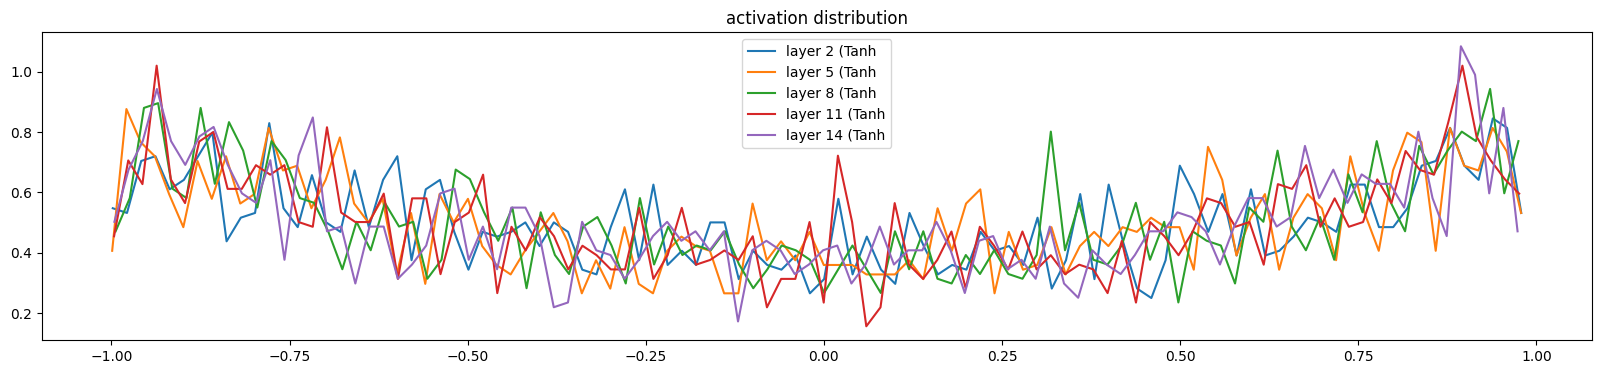

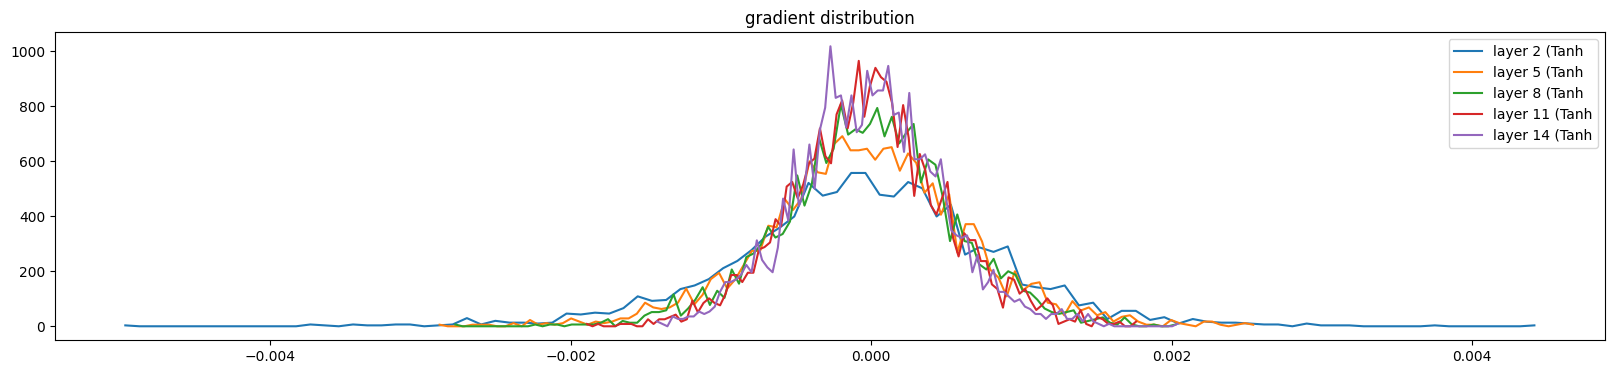

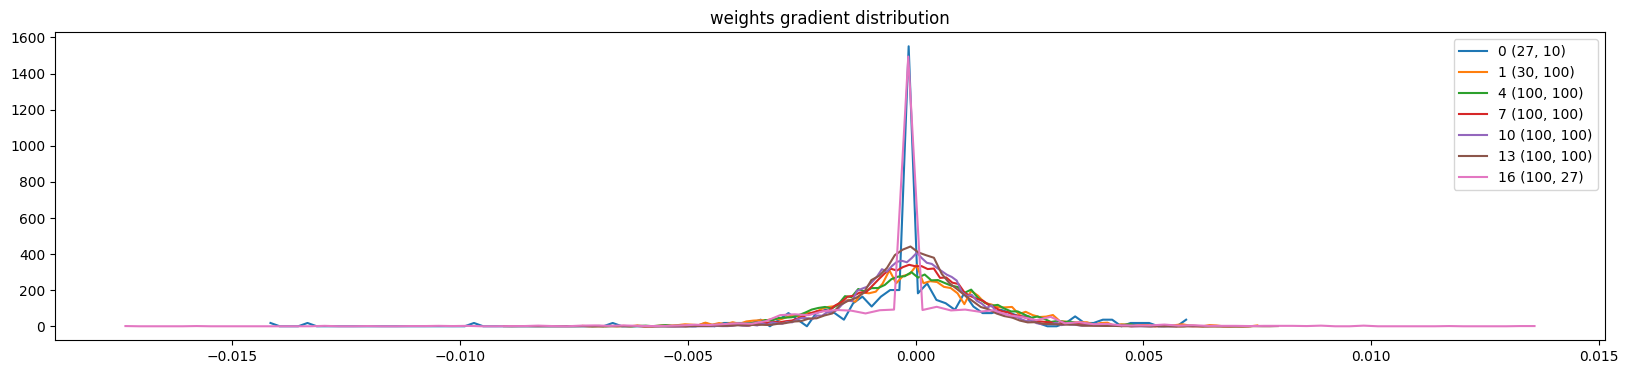

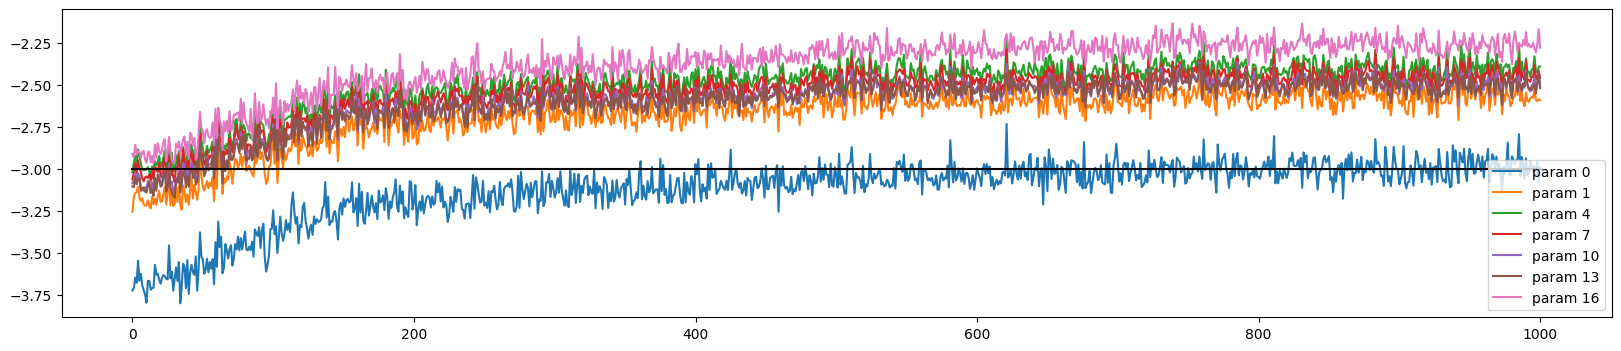

In [336]:
C, layers, parameters = initialize_parameters(tanh=True, bn=True, bnOutput=True, hidden_gain=5/3)
lossi, ud = train(breakpoint=0)
print("activations:")
visualize_activations_distribution(layers)
print("gradients:")
visualize_gradients_distribution(layers)
print("updates:")
visaulize_weight_distribution(parameters)
C, layers, parameters = initialize_parameters(tanh=True, bn=True, bnOutput=True, hidden_gain=5/3)
lossi, ud = train(breakpoint=1000)
print("update to param log ratio (10000 steps):")
visualize_update_to_param_log_ratio(parameters, ud)

Now let's see how the NN will behave in the face of some intentional misconfiguration. Setting the gain to 0.2:

47024
      0/ 200000: 3.3075
activations:
layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.84%
layer 5 (      Tanh): mean +0.01, std 0.66, saturated: 1.44%
layer 8 (      Tanh): mean -0.00, std 0.66, saturated: 1.12%
layer 11 (      Tanh): mean +0.00, std 0.67, saturated: 0.97%
layer 14 (      Tanh): mean -0.01, std 0.67, saturated: 0.25%
gradients:
layer 2 (      Tanh): mean +0.000000, std 1.184392e-03
layer 5 (      Tanh): mean +0.000000, std 9.880272e-04
layer 8 (      Tanh): mean +0.000000, std 8.797960e-04
layer 11 (      Tanh): mean +0.000000, std 8.671823e-04
layer 14 (      Tanh): mean +0.000000, std 9.938019e-04
updates:
weight   (27, 10) | mean +0.000000 | std 6.616924e-03 | grad:data ratio 6.607921e-03
weight  (30, 100) | mean -0.000047 | std 1.715399e-02 | grad:data ratio 2.783352e-01
weight (100, 100) | mean -0.000009 | std 7.366689e-03 | grad:data ratio 2.496354e-01
weight (100, 100) | mean -0.000041 | std 6.441066e-03 | grad:data ratio 2.387605e-01
weight (100, 

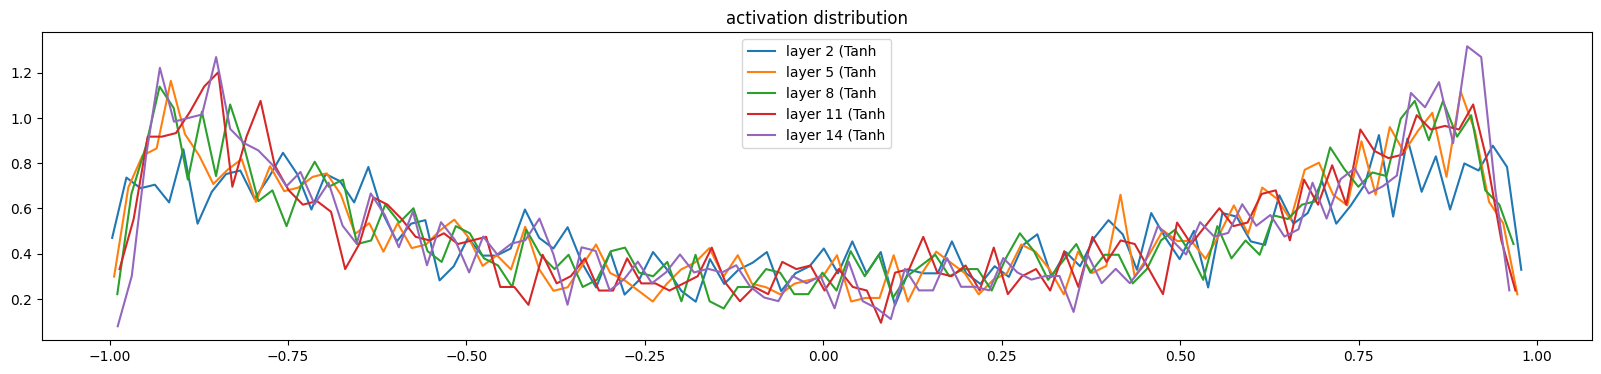

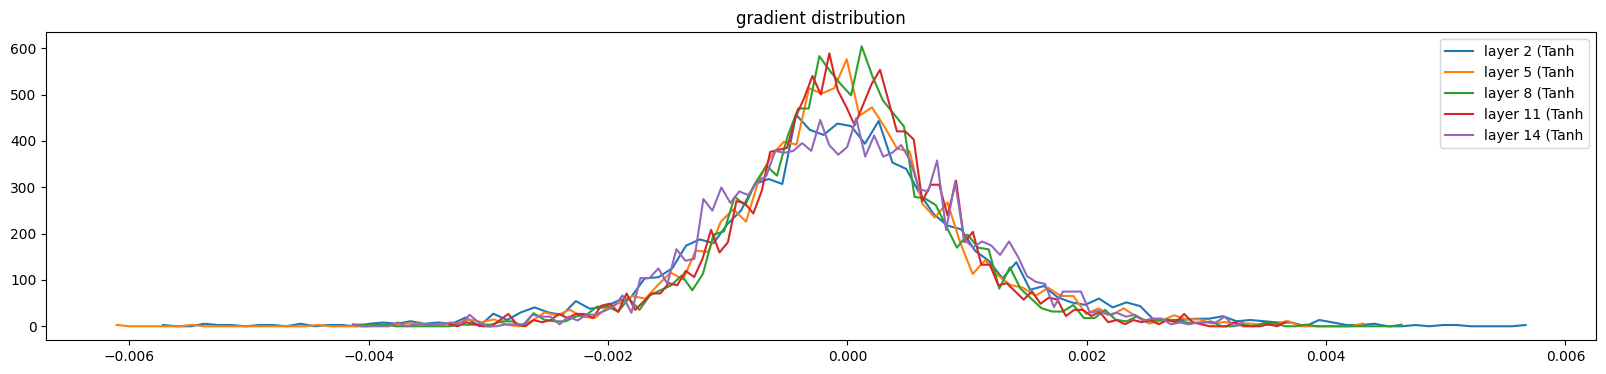

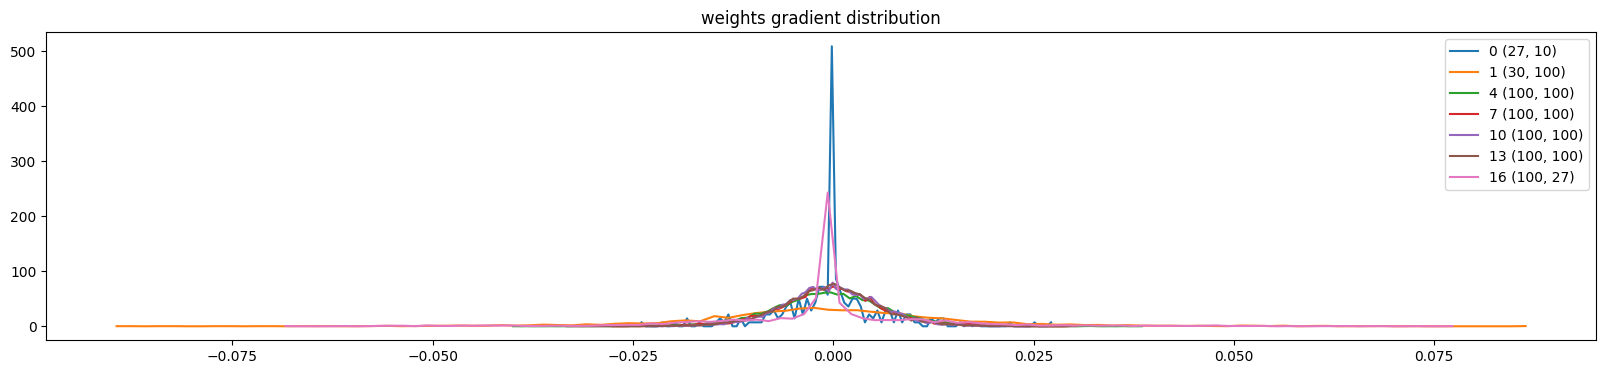

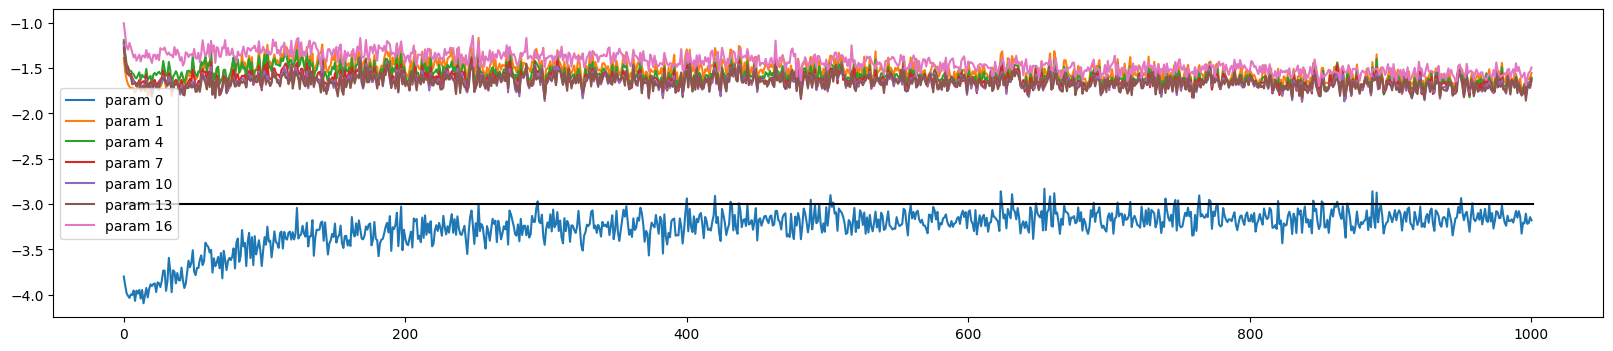

In [338]:
C, layers, parameters = initialize_parameters(tanh=True, bn=True, bnOutput=True, hidden_gain=0.2)
lossi, ud = train(breakpoint=1000)
print("activations:")
visualize_activations_distribution(layers)
print("gradients:")
visualize_gradients_distribution(layers)
print("updates:")
visaulize_weight_distribution(parameters)
print("update to param log ratio (10000 steps):")
visualize_update_to_param_log_ratio(parameters, ud)

Everything looks pretty much the same, even though the gain is intentianally set to a value which previously would have messed everything up.

The only thing that has changed are the updates. They have changed because the backward pass of the batch norm, and the way the scale of the incoming activations interacts in the batchnorm and its backward pass, is actually changing thr scale of the updates. So we still cannot set the gain to literally everything, but we have much more space for it and everything else is significantly more robust.

If you are changing sufficiently the scale of the activations that are coming into the batchnorms, you might need to retune the learning rate.

In the case of the previous example where everything is uncalibrated by a large factor, batch normalization will still prove to be extremly robust.

47024
      0/ 200000: 3.3358
activations:
layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.09%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 2.69%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean -0.00, std 0.63, saturated: 2.50%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.38%
gradients:
layer 2 (      Tanh): mean +0.000000, std 3.276260e-03
layer 5 (      Tanh): mean +0.000000, std 2.886863e-03
layer 8 (      Tanh): mean +0.000000, std 2.665474e-03
layer 11 (      Tanh): mean -0.000000, std 2.279584e-03
layer 14 (      Tanh): mean -0.000000, std 2.208330e-03
updates:
weight   (27, 10) | mean +0.000000 | std 8.477321e-03 | grad:data ratio 8.325979e-03
weight  (30, 100) | mean +0.000052 | std 1.057595e-03 | grad:data ratio 3.850130e-04
weight (100, 100) | mean -0.000007 | std 8.808360e-04 | grad:data ratio 5.868822e-04
weight (100, 100) | mean -0.000005 | std 8.221373e-04 | grad:data ratio 5.509536e-04
weight (100, 

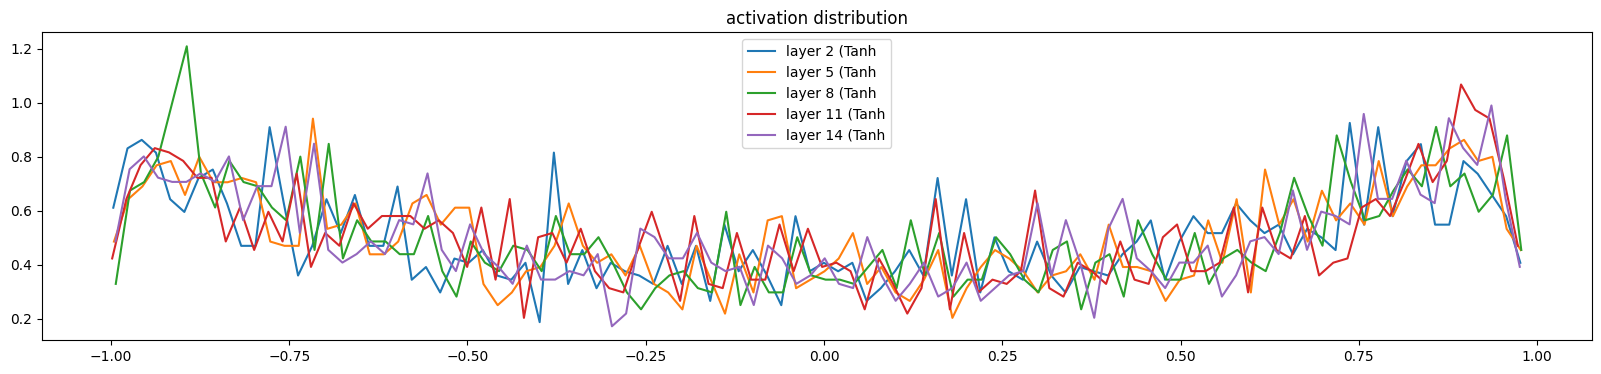

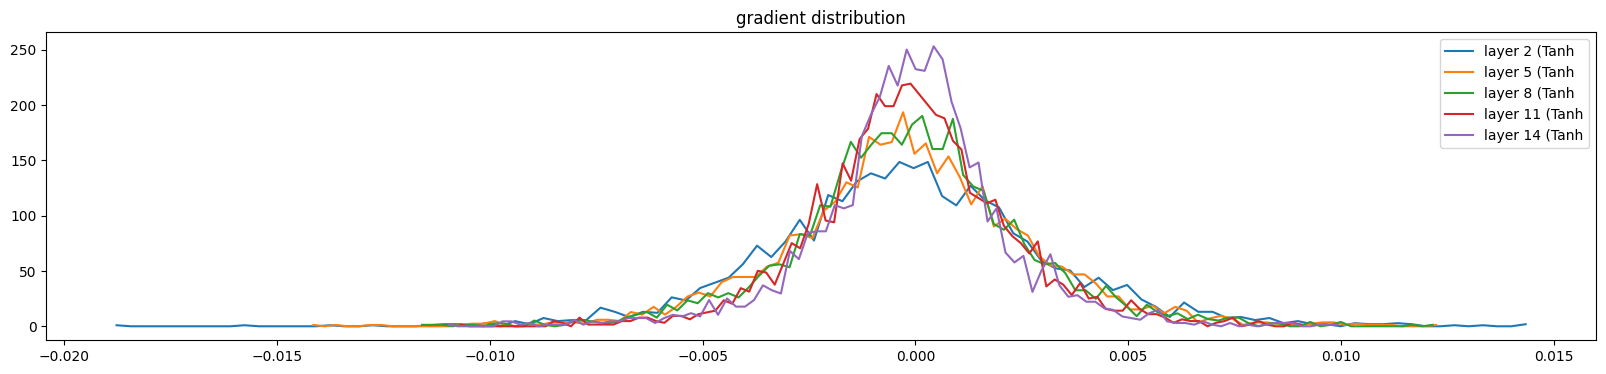

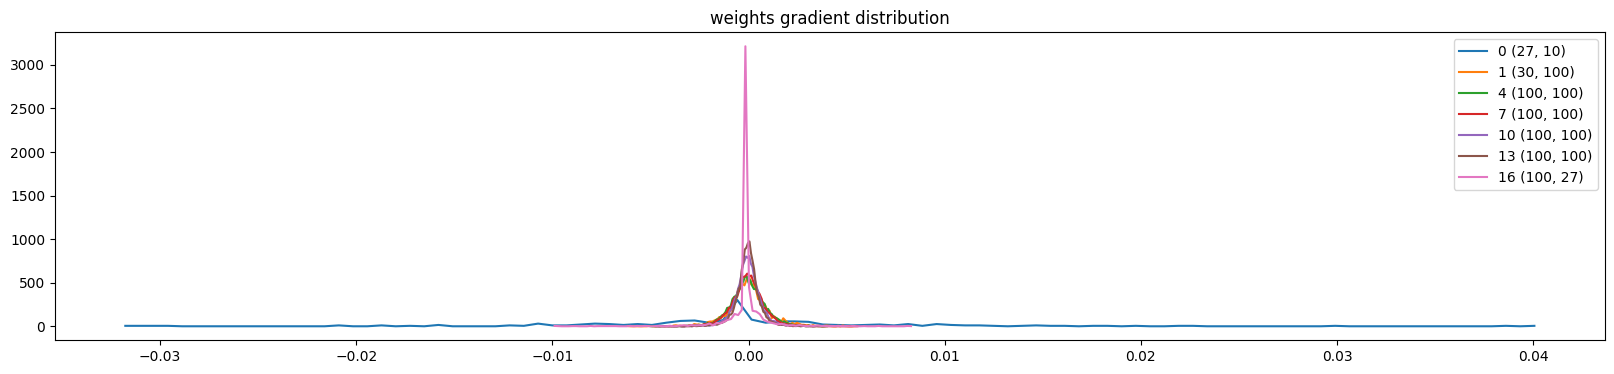

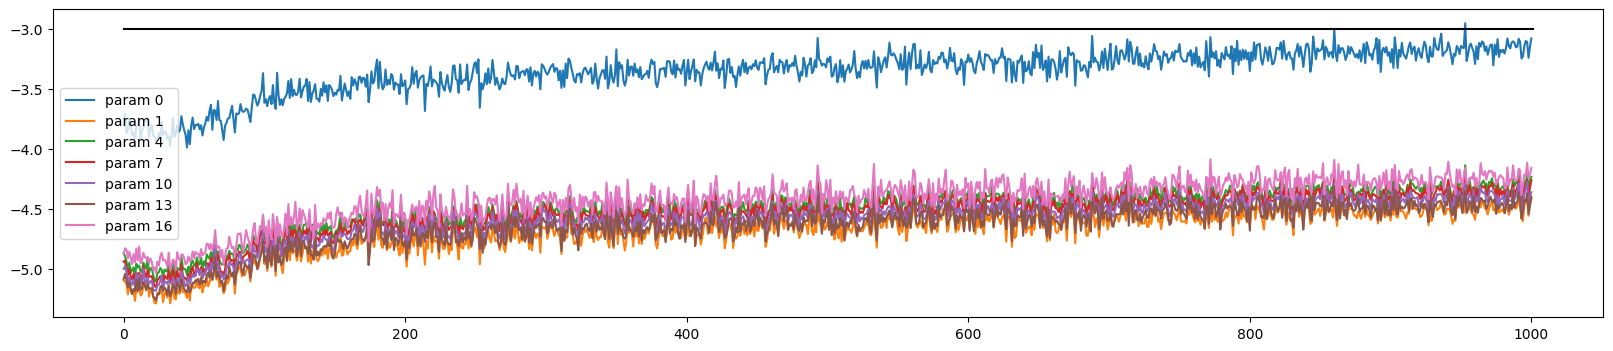

In [339]:
C, layers, parameters = initialize_parameters(tanh=True, bn=True, bnOutput=True, hidden_gain=15)
lossi, ud = train(breakpoint=1000)
print("activations:")
visualize_activations_distribution(layers)
print("gradients:")
visualize_gradients_distribution(layers)
print("updates:")
visaulize_weight_distribution(parameters)
print("update to param log ratio (10000 steps):")
visualize_update_to_param_log_ratio(parameters, ud)

The learning rate can be increased, roughly by 10.

47024
      0/ 200000: 3.2899
update to param log ratio (10000 steps):


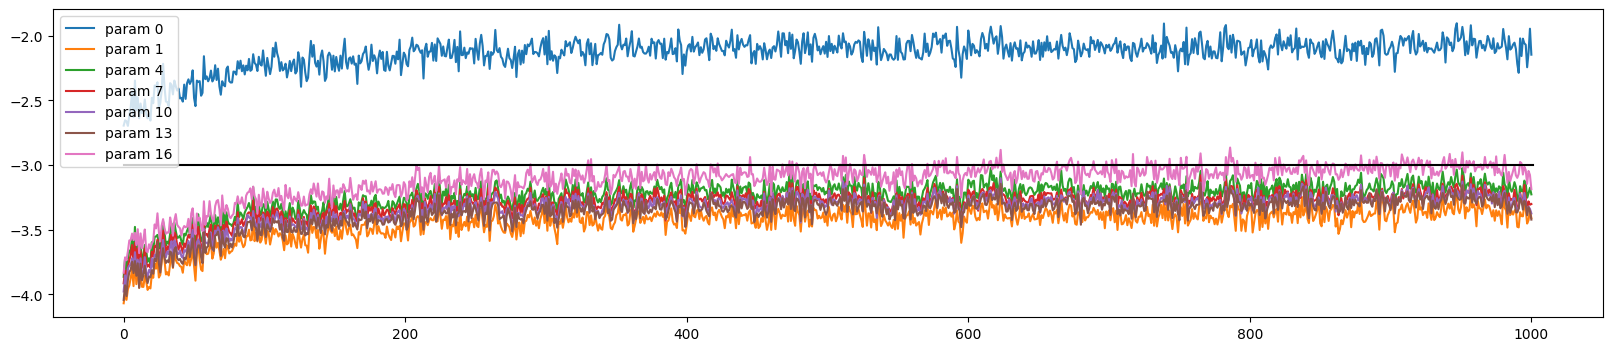

In [342]:
C, layers, parameters = initialize_parameters(tanh=True, bn=True, bnOutput=True, hidden_gain=15)
lossi, ud = train(breakpoint=1000, lr=1)
print("update to param log ratio (10000 steps):")
visualize_update_to_param_log_ratio(parameters, ud)

In [ ]:
C, layers, parameters = initialize_parameters(tanh=True, bn=True, bnOutput=True, hidden_gain=5/3)
_ = train(breakpoint=math.inf)

In [23]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(decode(i) for i in out)) # decode and print the generated word

montaymyah.
see.
med.
ryla.
reisha.
ejd.
legrazeem.
melin.
shi.
jenneden.
est.
aarvelyza.
houra.
noshubergiagrace.
kin.
renlee.
xithana.
ubakard.
ryyah.
fael.
